### DataSciene Spring 2019 Now You "C" Me Group
link to video: https://youtu.be/lhodcPtmywc

# RNA and hMeDIP Clustering and Data Exploration

## Information obtained from data cleaning

In the three previous notebooks I have cleaned up all of the data and created dataframes that contain info about all of the expressed genes. There is one dataframe for each data set (Human ARPE-19 cells treated with vitamin C, Rat Schwann cells treated with vitamin C, and Rat Schwann cells treated with cAMP). The columns (not necessarily in this order) are as follows: 

1. Ensembl ID: this is just the ID for each gene, will be used as the index
2. Change: meaning the change in transcription in response to either vitamin C or cAMP, this will be the label
3. Name: This is the gene name. I kept these so that we can look at the clusters later, but this will not be included in the analysis.
4. Biotype: Most of these are protein coding, so this will be changed to a binary classification of either protein coding or not protein coding
5. Chromosome: Should not be a confounding variable, but I thought I should include it for just in case.
6. Length: Entire transcript length, from transcription start site (TSS) to transcription termination site (TTS)
7. Exonic Length: Length of the coding transcript, exons only
8. TSS_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene's TSS
9. Downstream_Promoter_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene's downstream promoter (250 bp downstream to 3,000 bp downstream)
10. Gene_Body_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene body (from 3,000 bp downstream of the TSS to the TTS)
11. Upstream_Promoter_Downregulated: Number of peaks that decrease in 5hmC enrichment that are located in that gene's upstream promoter (250 bp upstream to 3,000 bp upstream)
12. TSS_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene's TSS
13. Downstream_Promoter_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene's downstream promoter (250 bp downstream to 3,000 bp downstream)
14. Gene_Body_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene body (from 3,000 bp downstream of the TSS to the TTS)
15. Upstream_Promoter_Nondifferential: Number of peaks that do not change in 5hmC enrichment that are located in that gene's upstream promoter (250 bp upstream to 3,000 bp upstream)
16. TSS_Upregulated: Number of peaks that increase in 5hmC enrichment that are located in that gene's TSS
17. Downstream_Promoter_Upregulated: Number of peaks that increae in 5hmC enrichment that are located in that gene's downstream promoter (250 bp downstream to 3,000 bp downstream)
18. Gene_Body_Upregulated: Number of peaks that increase in 5hmC enrichment that are located in that gene body (from 3,000 bp downstream of the TSS to the TTS)
19. Upstream_Promoter_Upregulated: Number of peaks that increase in 5hmC enrichment that are located in that gene's upstream promoter (250 bp upstream to 3,000 bp upstream)




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.decomposition import PCA 
from sklearn.preprocessing import scale

from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans, AgglomerativeClustering

import csv
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

In [2]:
cleaned_data_path = "Output_Tables_and_Results/"
output_path = "Clustering_Output/"

In [4]:
import os
os.listdir("Output_Tables_and_Results/")

['ARPE_Intermediate_Files',
 'SC_VitC_Combined_Cleaned_Data.csv',
 'SC_cAMP_Combined_Cleaned_Data.pkl',
 '.DS_Store',
 'ARPE_Combined_Cleaned_Data.csv',
 'ARPE_Combined_Cleaned_Data.pkl',
 'SC-VitC_Intermediate_Files',
 'SC-cAMP_Intermediate_Files',
 'SC_cAMP_Combined_Cleaned_Data.csv',
 'SC_VitC_Combined_Cleaned_Data.pkl']

In [5]:
ARPE_cleaned_dataset = pd.read_pickle(cleaned_data_path+"ARPE_Combined_Cleaned_Data.pkl")
SC_VitC_cleaned_dataset = pd.read_pickle(cleaned_data_path+"SC_VitC_Combined_Cleaned_Data.pkl")
SC_cAMP_cleaned_dataset = pd.read_pickle(cleaned_data_path+"SC_cAMP_Combined_Cleaned_Data.pkl")



In [6]:
ARPE_cleaned_dataset.head()

,Change,Name,Biotype,Chr,Length,Exonic Length,TSS_Downregulated,Downstream_Promoter_Downregulated,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,TSS_Nondifferential,Downstream_Promoter_Nondifferential,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,TSS_Upregulated,Downstream_Promoter_Upregulated,Gene_Body_Upregulated,Upstream_Promoter_Upregulated
Ensembl_ID,,,,,,,,,,,,,,,,,,
ENSG00000000003,Downregulated,TSPAN6,protein_coding,X,9996.0,3796.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000419,Nondifferential,DPM1,protein_coding,20,23689.0,1161.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ENSG00000000457,Nondifferential,SCYL3,protein_coding,1,44322.0,6364.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
ENSG00000000460,Nondifferential,C1orf112,protein_coding,1,58672.0,4355.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0
ENSG00000000971,Upregulated,CFH,protein_coding,1,95627.0,4127.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
SC_VitC_cleaned_dataset.head()

,Change,Gene_Name,Gene_Biotype,Chr,Length,Exon Length,Downstream_Promoter_Downregulated,Upstream_Promoter_Downregulated,Gene_Body_Downregulated,TSS_Downregulated,Downstream_Promoter_Nondifferential,Upstream_Promoter_Nondifferential,Gene_Body_Nondifferential,TSS_Nondifferential,Downstream_Promoter_Upregulated,Upstream_Promoter_Upregulated,Gene_Body_Upregulated,TSS_Upregulated
Ensembl_ID,,,,,,,,,,,,,,,,,,
ENSRNOG00000000001,Nondifferential,AABR07013255.1,pseudogene,2,1421,1416,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000008,Upregulated,Alx4,protein_coding,3,36573,1747,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0,4.0,0.0
ENSRNOG00000000017,Nondifferential,Steap1,protein_coding,4,10589,1280,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000021,Nondifferential,AABR07061902.1,pseudogene,4,1202,1200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000024,Nondifferential,Hebp1,protein_coding,4,29515,1062,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0


In [8]:
SC_cAMP_cleaned_dataset.head()

,Change,Gene_Name,Gene_Biotype,Chr,Length,Exon Length,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,Downstream_Promoter_Downregulated,TSS_Downregulated,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,Downstream_Promoter_Nondifferential,TSS_Nondifferential,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Downstream_Promoter_Upregulated,TSS_Upregulated
Gene_ID,,,,,,,,,,,,,,,,,,
ENSRNOG00000000001,Nondifferential,AABR07013255.1,pseudogene,2,1421,1416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000010,Downregulated,Cbln1,protein_coding,19,3810,2444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000017,Downregulated,Steap1,protein_coding,4,10589,1280,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ENSRNOG00000000021,Nondifferential,AABR07061902.1,pseudogene,4,1202,1200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000024,Downregulated,Hebp1,protein_coding,4,29515,1062,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
# sns.set()
# sns.pairplot(ARPE_cleaned_dataset, hue = "Change")
# plt.savefig(output_path+"ARPE_pairplot.png", dpi=300, figsize=(24, 24)) 

In [10]:
# sns.set()
# sns.pairplot(SC_VitC_cleaned_dataset, hue = "Change")
# plt.savefig(output_path+"SC_VitC_pairplot.png", dpi=300, figsize=(24, 24)) 

In [11]:
# sns.set()
# sns.pairplot(SC_cAMP_cleaned_dataset, hue = "Change")
# plt.savefig(output_path+"SC_cAMP_pairplot.png", dpi=300, figsize=(24, 24)) 

It is really hard to see these inline because there are too many variables so each individual portion looks very small, but I have saved the images to very large files (24x24 inches, 300 dpi) so that you can zoom in and look at them all clearly. I have put a # in front of each line so that if I restart and run all cells it won't try to redo these ones, as they take a few minutes each to generate. 

Findings from this pairplot: The density plots show that some types of peaks are less commonly found in the upregulated genes than in the downregulated or nondifferential genes (downstream promoter upregulated, downstream promoter downregulated, upstream promoter nondifferential). It looks like this might just mean that there are fewer peaks in general in the promoter regions of upregulated genes. There appear to be more peaks in the promoter regions for downregulated genes in general as well. Genebody upregulated and genebody nondifferential appear to be positively correlated. This appears consistent for all 3 datasets. 

Most of the variables do not appear to be correlated in any way. Ones that do appear to have some sort of correlation are Length and Exonic Length (looks somewhat positively correlated). Additionally, gene body nondifferential peaks appear to be somewhat correlated with Length (somewhat positively correlated). This apparent lack of correlation between variables doesn't say much. 




In [12]:
SC_cAMP_cleaned_dataset.columns.values

array(['Change', 'Gene_Name', 'Gene_Biotype', 'Chr', 'Length',
       'Exon Length', 'Gene_Body_Downregulated',
       'Upstream_Promoter_Downregulated',
       'Downstream_Promoter_Downregulated', 'TSS_Downregulated',
       'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
       'Downstream_Promoter_Nondifferential', 'TSS_Nondifferential',
       'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
       'Downstream_Promoter_Upregulated', 'TSS_Upregulated'], dtype=object)

In [13]:
SC_cAMP_cleaned_dataset["Change_down"] = SC_cAMP_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Downregulated" else 0)
SC_cAMP_cleaned_dataset["Change_up"] = SC_cAMP_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Upregulated" else 0)
SC_cAMP_cleaned_dataset["Change_nondiff"] = SC_cAMP_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Nondifferential" else 0)


In [14]:
SC_cAMP_cleaned_dataset.rename(columns = {"Exon Length": "Exon_Length"}, inplace = True)

In [15]:
SC_cAMP_cleaned_dataset.tail(10)

,Change,Gene_Name,Gene_Biotype,Chr,Length,Exon_Length,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,Downstream_Promoter_Downregulated,TSS_Downregulated,...,Upstream_Promoter_Nondifferential,Downstream_Promoter_Nondifferential,TSS_Nondifferential,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Downstream_Promoter_Upregulated,TSS_Upregulated,Change_down,Change_up,Change_nondiff
Gene_ID,,,,,,,,,,,,,,,,,,,,,
ENSRNOG00000062253,Nondifferential,Rn60_2_0037.2,processed_pseudogene,2,481,481,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
ENSRNOG00000062261,Upregulated,Rn60_15_0518.2,lincRNA,15,478,478,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
ENSRNOG00000062272,Nondifferential,Rn60_17_0157.2,processed_pseudogene,17,400,400,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
ENSRNOG00000062279,Downregulated,Cln5,protein_coding,15,4431,509,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
ENSRNOG00000062289,Nondifferential,Rn60_7_0127.5,antisense_RNA,7,1579,443,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
ENSRNOG00000062294,Nondifferential,Rn60_17_0156.3,antisense_RNA,17,3489,495,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
ENSRNOG00000062296,Nondifferential,Rn60_X_0201.2,processed_pseudogene,X,842,842,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
ENSRNOG00000062298,Upregulated,Rpl13a,protein_coding,1,3078,1039,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
ENSRNOG00000062306,Nondifferential,Cyp4f17,protein_coding,7,16269,2132,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1


In [16]:
multiple = sm.ols(formula="""Change_down ~ Gene_Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=SC_cAMP_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Change_down   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     17.64
Date:                Wed, 17 Apr 2019   Prob (F-statistic):          4.82e-174
Time:                        19:32:08   Log-Likelihood:                -7453.5
No. Observations:               12165   AIC:                         1.503e+04
Df Residuals:                   12104   BIC:                         1.548e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.2644      0.068      3.904      0.000       0.132       0.397
Gene_Biotype[T.Mt_rRNA]                             -0.1057      0.347     -0.305      0.760      -0.785       0.574
Gene_Biotype[T.Mt_tRNA]                             -0.0725      0.220     -0.329      0.742      -0.504       0.359
Gene_Biotype[T.TEC]                                 -0.3582      0.267     -1.340      0.180      -0.882       0.166
Gene_Biotype[T.antisense_RNA]                       -0.1298      0.121     -1.077      0.281      -0.366       0.106
Gene_Biotype[T.lincRNA]                              0.0177      0.073      0.242      0.808      -0.125       0.161
Gene_Biotype[T.miRNA]                               -0.0738      0.083     -0.891      0.373      -0.236       0.089
Gene_Biotype[T.misc_RNA]                            -0.2777      0.101     -2.748      0.006      -0.476      -0.080
Gene_Biotype[T.processed_pseudogene]                -0.2497      0.079     -3.164      0.002      -0.404      -0.095
Gene_Biotype[T.processed_transcript]                -0.2139      0.099     -2.155      0.031      -0.409      -0.019
Gene_Biotype[T.protein_coding]                      -0.0950      0.067     -1.418      0.156      -0.226       0.036
Gene_Biotype[T.pseudogene]                          -0.1350      0.076     -1.777      0.076      -0.284       0.014
Gene_Biotype[T.rRNA]                                -0.2758      0.267     -1.033      0.302      -0.799       0.248
Gene_Biotype[T.ribozyme]                            -0.3343      0.324     -1.032      0.302      -0.969       0.300
Gene_Biotype[T.scaRNA]                              -0.3454      0.234     -1.476      0.140      -0.804       0.113
Gene_Biotype[T.snRNA]                               -0.2632      0.079     -3.337      0.001      -0.418      -0.109
Gene_Biotype[T.snoRNA]                              -0.1301      0.081     -1.604      0.109      -0.289       0.029
Gene_Biotype[T.transcribed_processed_pseudogene]    -0.3689      0.234     -1.575      0.115      -0.828       0.090
Gene_Biotype[T.unprocessed_pseudogene]              -0.4002      0.182     -2.197      0.028      -0.757      -0.043
Chr[T.10]                                           -0.0308      0.018     -1.681      0.093      -0.067       0.005
Chr[T.11]                                            0.0412      0.028      1.485      0.138      -0.013       0.096
Chr[T.12]                                           -0.0309      0.025     -1.218      0.223      -0.081       0.019
Chr[T.13]                                            0.0949      0.027      3.552      0.000       0.043       0.147
Chr[T.14]                                

In [17]:
multiple = sm.ols(formula="""Change_up ~ Gene_Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=SC_cAMP_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Change_up   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     8.774
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           7.71e-74
Time:                        19:32:08   Log-Likelihood:                -8052.5
No. Observations:               12165   AIC:                         1.623e+04
Df Residuals:                   12104   BIC:                         1.668e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.2459      0.071      3.456      0.001       0.106       0.385
Gene_Biotype[T.Mt_rRNA]                              0.3706      0.364      1.018      0.309      -0.343       1.084
Gene_Biotype[T.Mt_tRNA]                             -0.3694      0.231     -1.596      0.110      -0.823       0.084
Gene_Biotype[T.TEC]                                 -0.1650      0.281     -0.588      0.557      -0.715       0.385
Gene_Biotype[T.antisense_RNA]                        0.0951      0.127      0.751      0.453      -0.153       0.343
Gene_Biotype[T.lincRNA]                              0.0758      0.077      0.989      0.323      -0.074       0.226
Gene_Biotype[T.miRNA]                               -0.1274      0.087     -1.464      0.143      -0.298       0.043
Gene_Biotype[T.misc_RNA]                            -0.1423      0.106     -1.341      0.180      -0.350       0.066
Gene_Biotype[T.processed_pseudogene]                 0.1354      0.083      1.633      0.102      -0.027       0.298
Gene_Biotype[T.processed_transcript]                 0.2113      0.104      2.026      0.043       0.007       0.416
Gene_Biotype[T.protein_coding]                       0.2084      0.070      2.963      0.003       0.071       0.346
Gene_Biotype[T.pseudogene]                           0.1339      0.080      1.678      0.093      -0.023       0.290
Gene_Biotype[T.rRNA]                                 0.0879      0.281      0.313      0.754      -0.462       0.638
Gene_Biotype[T.ribozyme]                             0.8005      0.340      2.353      0.019       0.134       1.467
Gene_Biotype[T.scaRNA]                               0.0333      0.246      0.136      0.892      -0.448       0.515
Gene_Biotype[T.snRNA]                               -0.0276      0.083     -0.333      0.739      -0.190       0.135
Gene_Biotype[T.snoRNA]                              -0.0434      0.085     -0.509      0.611      -0.210       0.124
Gene_Biotype[T.transcribed_processed_pseudogene]     0.3187      0.246      1.296      0.195      -0.163       0.801
Gene_Biotype[T.unprocessed_pseudogene]              -0.0295      0.191     -0.154      0.878      -0.405       0.346
Chr[T.10]                                            0.0381      0.019      1.978      0.048       0.000       0.076
Chr[T.11]                                           -0.0049      0.029     -0.167      0.868      -0.062       0.052
Chr[T.12]                                            0.0157      0.027      0.591      0.555      -0.036       0.068
Chr[T.13]                                           -0.0489      0.028     -1.742      0.082      -0.104       0.006
Chr[T.14]                                

In [18]:
multiple = sm.ols(formula="""Change_nondiff ~ Gene_Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=SC_cAMP_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Change_nondiff   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     8.994
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           2.74e-76
Time:                        19:32:08   Log-Likelihood:                -7768.6
No. Observations:               12165   AIC:                         1.566e+04
Df Residuals:                   12104   BIC:                         1.611e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.4897      0.069      7.047      0.000       0.354       0.626
Gene_Biotype[T.Mt_rRNA]                             -0.2649      0.356     -0.745      0.456      -0.962       0.432
Gene_Biotype[T.Mt_tRNA]                              0.4419      0.226      1.955      0.051      -0.001       0.885
Gene_Biotype[T.TEC]                                  0.5231      0.274      1.907      0.056      -0.014       1.061
Gene_Biotype[T.antisense_RNA]                        0.0347      0.124      0.281      0.779      -0.208       0.277
Gene_Biotype[T.lincRNA]                             -0.0935      0.075     -1.248      0.212      -0.240       0.053
Gene_Biotype[T.miRNA]                                0.2012      0.085      2.367      0.018       0.035       0.368
Gene_Biotype[T.misc_RNA]                             0.4200      0.104      4.051      0.000       0.217       0.623
Gene_Biotype[T.processed_pseudogene]                 0.1143      0.081      1.411      0.158      -0.044       0.273
Gene_Biotype[T.processed_transcript]                 0.0026      0.102      0.025      0.980      -0.197       0.202
Gene_Biotype[T.protein_coding]                      -0.1134      0.069     -1.651      0.099      -0.248       0.021
Gene_Biotype[T.pseudogene]                           0.0011      0.078      0.014      0.989      -0.152       0.154
Gene_Biotype[T.rRNA]                                 0.1879      0.274      0.686      0.493      -0.349       0.725
Gene_Biotype[T.ribozyme]                            -0.4662      0.332     -1.403      0.161      -1.118       0.185
Gene_Biotype[T.scaRNA]                               0.3121      0.240      1.300      0.194      -0.159       0.783
Gene_Biotype[T.snRNA]                                0.2908      0.081      3.593      0.000       0.132       0.449
Gene_Biotype[T.snoRNA]                               0.1735      0.083      2.084      0.037       0.010       0.337
Gene_Biotype[T.transcribed_processed_pseudogene]     0.0502      0.240      0.209      0.834      -0.421       0.521
Gene_Biotype[T.unprocessed_pseudogene]               0.4297      0.187      2.299      0.022       0.063       0.796
Chr[T.10]                                           -0.0073      0.019     -0.387      0.699      -0.044       0.030
Chr[T.11]                                           -0.0363      0.028     -1.276      0.202      -0.092       0.019
Chr[T.12]                                            0.0152      0.026      0.582      0.561      -0.036       0.066
Chr[T.13]                                           -0.0460      0.027     -1.678      0.093      -0.100       0.008
Chr[T.14]                                

In [19]:

SC_VitC_cleaned_dataset["Change_down"] = SC_VitC_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Downregulated" else 0)
SC_VitC_cleaned_dataset["Change_up"] = SC_VitC_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Upregulated" else 0)
SC_VitC_cleaned_dataset["Change_nondiff"] = SC_VitC_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Nondifferential" else 0)
SC_VitC_cleaned_dataset.rename(columns = {"Exon Length": "Exon_Length"}, inplace = True)


In [20]:
SC_VitC_cleaned_dataset.head()

,Change,Gene_Name,Gene_Biotype,Chr,Length,Exon_Length,Downstream_Promoter_Downregulated,Upstream_Promoter_Downregulated,Gene_Body_Downregulated,TSS_Downregulated,...,Upstream_Promoter_Nondifferential,Gene_Body_Nondifferential,TSS_Nondifferential,Downstream_Promoter_Upregulated,Upstream_Promoter_Upregulated,Gene_Body_Upregulated,TSS_Upregulated,Change_down,Change_up,Change_nondiff
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSRNOG00000000001,Nondifferential,AABR07013255.1,pseudogene,2,1421,1416,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
ENSRNOG00000000008,Upregulated,Alx4,protein_coding,3,36573,1747,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,1.0,1.0,4.0,0.0,0,1,0
ENSRNOG00000000017,Nondifferential,Steap1,protein_coding,4,10589,1280,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
ENSRNOG00000000021,Nondifferential,AABR07061902.1,pseudogene,4,1202,1200,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
ENSRNOG00000000024,Nondifferential,Hebp1,protein_coding,4,29515,1062,0.0,0.0,1.0,0.0,...,0.0,5.0,0.0,0.0,0.0,2.0,0.0,0,0,1


In [21]:
multiple = sm.ols(formula="""Change_down ~ Gene_Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=SC_VitC_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Change_down   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     6.630
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           2.60e-50
Time:                        19:32:09   Log-Likelihood:                -4463.2
No. Observations:               12152   AIC:                             9048.
Df Residuals:                   12091   BIC:                             9500.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.1298      0.054      2.424      0.015       0.025       0.235
Gene_Biotype[T.Mt_rRNA]                              0.0930      0.271      0.343      0.732      -0.439       0.625
Gene_Biotype[T.Mt_tRNA]                              0.0777      0.157      0.497      0.620      -0.229       0.385
Gene_Biotype[T.TEC]                                 -0.1208      0.209     -0.577      0.564      -0.531       0.289
Gene_Biotype[T.antisense_RNA]                       -0.0984      0.118     -0.832      0.405      -0.330       0.133
Gene_Biotype[T.lincRNA]                             -0.0809      0.058     -1.390      0.165      -0.195       0.033
Gene_Biotype[T.miRNA]                               -0.1180      0.063     -1.875      0.061      -0.241       0.005
Gene_Biotype[T.misc_RNA]                            -0.1048      0.081     -1.286      0.199      -0.264       0.055
Gene_Biotype[T.processed_pseudogene]                -0.0775      0.061     -1.274      0.203      -0.197       0.042
Gene_Biotype[T.processed_transcript]                 0.0385      0.081      0.474      0.635      -0.121       0.198
Gene_Biotype[T.protein_coding]                       0.0880      0.053      1.662      0.097      -0.016       0.192
Gene_Biotype[T.pseudogene]                           0.0093      0.059      0.157      0.875      -0.107       0.126
Gene_Biotype[T.rRNA]                                -0.1125      0.253     -0.444      0.657      -0.609       0.384
Gene_Biotype[T.ribozyme]                             0.4107      0.183      2.243      0.025       0.052       0.770
Gene_Biotype[T.scaRNA]                              -0.0984      0.143     -0.689      0.491      -0.378       0.181
Gene_Biotype[T.snRNA]                               -0.0449      0.066     -0.675      0.500      -0.175       0.085
Gene_Biotype[T.snoRNA]                              -0.1160      0.066     -1.748      0.080      -0.246       0.014
Gene_Biotype[T.transcribed_processed_pseudogene]    -0.0934      0.253     -0.368      0.713      -0.590       0.404
Gene_Biotype[T.unprocessed_pseudogene]              -0.1016      0.135     -0.754      0.451      -0.366       0.163
Chr[T.10]                                           -0.0052      0.014     -0.367      0.714      -0.033       0.023
Chr[T.11]                                           -0.0015      0.022     -0.069      0.945      -0.045       0.042
Chr[T.12]                                           -0.0310      0.020     -1.586      0.113      -0.069       0.007
Chr[T.13]                                           -0.0129      0.021     -0.620      0.535      -0.054       0.028
Chr[T.14]                                

In [22]:
multiple = sm.ols(formula="""Change_up ~ Gene_Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=SC_VitC_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Change_up   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     19.47
Date:                Wed, 17 Apr 2019   Prob (F-statistic):          1.11e-194
Time:                        19:32:09   Log-Likelihood:                -4587.6
No. Observations:               12152   AIC:                             9297.
Df Residuals:                   12091   BIC:                             9749.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.0574      0.054      1.060      0.289      -0.049       0.163
Gene_Biotype[T.Mt_rRNA]                             -0.0057      0.274     -0.021      0.983      -0.543       0.531
Gene_Biotype[T.Mt_tRNA]                              0.0125      0.158      0.079      0.937      -0.298       0.322
Gene_Biotype[T.TEC]                                 -0.0805      0.211     -0.381      0.703      -0.495       0.334
Gene_Biotype[T.antisense_RNA]                        0.1022      0.119      0.855      0.393      -0.132       0.336
Gene_Biotype[T.lincRNA]                              0.0859      0.059      1.460      0.144      -0.029       0.201
Gene_Biotype[T.miRNA]                               -0.0368      0.064     -0.579      0.563      -0.161       0.088
Gene_Biotype[T.misc_RNA]                            -0.0448      0.082     -0.545      0.586      -0.206       0.117
Gene_Biotype[T.processed_pseudogene]                -0.0599      0.061     -0.974      0.330      -0.180       0.061
Gene_Biotype[T.processed_transcript]                -0.0005      0.082     -0.006      0.995      -0.161       0.160
Gene_Biotype[T.protein_coding]                       0.0002      0.054      0.003      0.998      -0.105       0.105
Gene_Biotype[T.pseudogene]                          -0.0487      0.060     -0.812      0.417      -0.166       0.069
Gene_Biotype[T.rRNA]                                -0.0397      0.256     -0.155      0.877      -0.542       0.462
Gene_Biotype[T.ribozyme]                            -0.0652      0.185     -0.352      0.725      -0.428       0.297
Gene_Biotype[T.scaRNA]                              -0.0677      0.144     -0.470      0.639      -0.350       0.215
Gene_Biotype[T.snRNA]                               -0.0728      0.067     -1.085      0.278      -0.204       0.059
Gene_Biotype[T.snoRNA]                              -0.0522      0.067     -0.778      0.436      -0.184       0.079
Gene_Biotype[T.transcribed_processed_pseudogene]    -0.1165      0.256     -0.455      0.649      -0.618       0.385
Gene_Biotype[T.unprocessed_pseudogene]               0.0122      0.136      0.090      0.929      -0.255       0.279
Chr[T.10]                                           -0.0439      0.014     -3.069      0.002      -0.072      -0.016
Chr[T.11]                                           -0.0126      0.022     -0.564      0.573      -0.057       0.031
Chr[T.12]                                           -0.0295      0.020     -1.494      0.135      -0.068       0.009
Chr[T.13]                                           -0.0031      0.021     -0.149      0.882      -0.044       0.038
Chr[T.14]                                

In [23]:
multiple = sm.ols(formula="""Change_nondiff ~ Gene_Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=SC_VitC_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Change_nondiff   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     10.36
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           1.34e-91
Time:                        19:32:09   Log-Likelihood:                -7580.7
No. Observations:               12152   AIC:                         1.528e+04
Df Residuals:                   12091   BIC:                         1.574e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.8128      0.069     11.740      0.000       0.677       0.948
Gene_Biotype[T.Mt_rRNA]                             -0.0872      0.351     -0.249      0.803      -0.774       0.600
Gene_Biotype[T.Mt_tRNA]                             -0.0902      0.202     -0.446      0.656      -0.487       0.306
Gene_Biotype[T.TEC]                                  0.2013      0.270      0.744      0.457      -0.329       0.731
Gene_Biotype[T.antisense_RNA]                       -0.0038      0.153     -0.025      0.980      -0.303       0.296
Gene_Biotype[T.lincRNA]                             -0.0050      0.075     -0.066      0.947      -0.152       0.142
Gene_Biotype[T.miRNA]                                0.1548      0.081      1.904      0.057      -0.005       0.314
Gene_Biotype[T.misc_RNA]                             0.1496      0.105      1.420      0.156      -0.057       0.356
Gene_Biotype[T.processed_pseudogene]                 0.1374      0.079      1.747      0.081      -0.017       0.291
Gene_Biotype[T.processed_transcript]                -0.0380      0.105     -0.362      0.717      -0.244       0.168
Gene_Biotype[T.protein_coding]                      -0.0882      0.068     -1.288      0.198      -0.222       0.046
Gene_Biotype[T.pseudogene]                           0.0394      0.077      0.513      0.608      -0.111       0.190
Gene_Biotype[T.rRNA]                                 0.1521      0.328      0.465      0.642      -0.490       0.794
Gene_Biotype[T.ribozyme]                            -0.3455      0.237     -1.460      0.144      -0.810       0.118
Gene_Biotype[T.scaRNA]                               0.1661      0.184      0.900      0.368      -0.195       0.528
Gene_Biotype[T.snRNA]                                0.1177      0.086      1.370      0.171      -0.051       0.286
Gene_Biotype[T.snoRNA]                               0.1681      0.086      1.961      0.050    7.74e-05       0.336
Gene_Biotype[T.transcribed_processed_pseudogene]     0.2099      0.328      0.641      0.522      -0.432       0.852
Gene_Biotype[T.unprocessed_pseudogene]               0.0894      0.174      0.513      0.608      -0.252       0.431
Chr[T.10]                                            0.0491      0.018      2.683      0.007       0.013       0.085
Chr[T.11]                                            0.0142      0.029      0.494      0.621      -0.042       0.070
Chr[T.12]                                            0.0605      0.025      2.395      0.017       0.011       0.110
Chr[T.13]                                            0.0160      0.027      0.596      0.551      -0.037       0.069
Chr[T.14]                                

In [24]:
ARPE_cleaned_dataset
ARPE_cleaned_dataset["Change_down"] = ARPE_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Downregulated" else 0)
ARPE_cleaned_dataset["Change_up"] = ARPE_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Upregulated" else 0)
ARPE_cleaned_dataset["Change_nondiff"] = ARPE_cleaned_dataset["Change"].apply(lambda x: 1 if x == "Nondifferential" else 0)
ARPE_cleaned_dataset.rename(columns = {"Exonic Length": "Exon_Length"}, inplace = True)


In [25]:
ARPE_cleaned_dataset.head()

,Change,Name,Biotype,Chr,Length,Exon_Length,TSS_Downregulated,Downstream_Promoter_Downregulated,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,...,Downstream_Promoter_Nondifferential,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,TSS_Upregulated,Downstream_Promoter_Upregulated,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Change_down,Change_up,Change_nondiff
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,Downregulated,TSPAN6,protein_coding,X,9996.0,3796.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
ENSG00000000419,Nondifferential,DPM1,protein_coding,20,23689.0,1161.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1
ENSG00000000457,Nondifferential,SCYL3,protein_coding,1,44322.0,6364.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,1
ENSG00000000460,Nondifferential,C1orf112,protein_coding,1,58672.0,4355.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0,0,1
ENSG00000000971,Upregulated,CFH,protein_coding,1,95627.0,4127.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0


In [26]:
ARPE_cleaned_dataset.columns.values

array(['Change', 'Name', 'Biotype', 'Chr', 'Length', 'Exon_Length',
       'TSS_Downregulated', 'Downstream_Promoter_Downregulated',
       'Gene_Body_Downregulated', 'Upstream_Promoter_Downregulated',
       'TSS_Nondifferential', 'Downstream_Promoter_Nondifferential',
       'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
       'TSS_Upregulated', 'Downstream_Promoter_Upregulated',
       'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
       'Change_down', 'Change_up', 'Change_nondiff'], dtype=object)

In [27]:
multiple = sm.ols(formula="""Change_nondiff ~ Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=ARPE_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Change_nondiff   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     16.27
Date:                Wed, 17 Apr 2019   Prob (F-statistic):          1.12e-179
Time:                        19:32:09   Log-Likelihood:                -9053.0
No. Observations:               14599   AIC:                         1.824e+04
Df Residuals:                   14530   BIC:                         1.877e+04
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         0.9981      0.202      4.941      0.000       0.602       1.394
Biotype[T.IG_V_gene]                              0.0249      0.378      0.066      0.948      -0.717       0.766
Biotype[T.Mt_rRNA]                                0.0004      0.398      0.001      0.999      -0.779       0.780
Biotype[T.Mt_tRNA]                               -0.0047      0.274     -0.017      0.986      -0.541       0.532
Biotype[T.TEC]                                   -0.1135      0.219     -0.518      0.604      -0.543       0.316
Biotype[T.TR_C_gene]                             -0.9253      0.495     -1.871      0.061      -1.895       0.044
Biotype[T.TR_J_gene]                             -0.0113      0.234     -0.048      0.961      -0.470       0.447
Biotype[T.TR_J_pseudogene]                        0.0179      0.494      0.036      0.971      -0.951       0.987
Biotype[T.antisense_RNA]                         -0.1642      0.202     -0.812      0.417      -0.561       0.232
Biotype[T.bidirectional_promoter_lncRNA]          0.0222      0.285      0.078      0.938      -0.537       0.582
Biotype[T.lincRNA]                               -0.2553      0.202     -1.262      0.207      -0.652       0.141
Biotype[T.miRNA]                                  0.0090      0.224      0.040      0.968      -0.429       0.447
Biotype[T.misc_RNA]                              -0.1064      0.216     -0.492      0.622      -0.530       0.317
Biotype[T.processed_pseudogene]                  -0.2628      0.203     -1.296      0.195      -0.660       0.135
Biotype[T.processed_transcript]                  -0.1673      0.205     -0.817      0.414      -0.569       0.234
Biotype[T.protein_coding]                        -0.2320      0.202     -1.149      0.251      -0.628       0.164
Biotype[T.scRNA]                                  0.0002      0.494      0.000      1.000      -0.968       0.969
Biotype[T.sense_intronic]                        -0.4221      0.377     -1.118      0.263      -1.162       0.318
Biotype[T.sense_overlapping]                     -0.1307      0.212     -0.617      0.537      -0.546       0.284
Biotype[T.snRNA]                                 -0.0766      0.212     -0.361      0.718      -0.492       0.339
Biotype[T.snoRNA]                                -0.0039      0.252     -0.016      0.987      -0.497       0.490
Biotype[T.transcribed_processed_pseudogene]      -0.2186      0.211     -1.034      0.301      -0.633       0.196
Biotype[T.transcribed_unitary_pseudogene]        -0.2102      0.226     -0.931      0.352      -0.653       0.232
Biotype[T.transcribed_unprocessed_pseudogene]    -0.2269      0.205     -1.107      0.268      -0.629       0.175
Bioty

In [28]:
multiple = sm.ols(formula="""Change_up ~ Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=ARPE_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Change_up   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     26.60
Date:                Wed, 17 Apr 2019   Prob (F-statistic):          5.98e-312
Time:                        19:32:10   Log-Likelihood:                -7073.6
No. Observations:               14599   AIC:                         1.429e+04
Df Residuals:                   14530   BIC:                         1.481e+04
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         0.0243      0.176      0.137      0.891      -0.322       0.370
Biotype[T.IG_V_gene]                             -0.0583      0.330     -0.177      0.860      -0.706       0.589
Biotype[T.Mt_rRNA]                               -0.1071      0.347     -0.309      0.758      -0.788       0.573
Biotype[T.Mt_tRNA]                               -0.1024      0.239     -0.429      0.668      -0.571       0.366
Biotype[T.TEC]                                    0.0349      0.191      0.183      0.855      -0.340       0.410
Biotype[T.TR_C_gene]                              0.9141      0.432      2.117      0.034       0.068       1.761
Biotype[T.TR_J_gene]                              0.0101      0.204      0.049      0.961      -0.390       0.410
Biotype[T.TR_J_pseudogene]                       -0.0234      0.432     -0.054      0.957      -0.870       0.823
Biotype[T.antisense_RNA]                          0.0719      0.177      0.407      0.684      -0.274       0.418
Biotype[T.bidirectional_promoter_lncRNA]         -0.0242      0.249     -0.097      0.923      -0.513       0.464
Biotype[T.lincRNA]                                0.1346      0.177      0.762      0.446      -0.212       0.481
Biotype[T.miRNA]                                 -0.0046      0.195     -0.023      0.981      -0.387       0.378
Biotype[T.misc_RNA]                               0.0183      0.189      0.097      0.923      -0.352       0.388
Biotype[T.processed_pseudogene]                   0.0050      0.177      0.028      0.977      -0.342       0.352
Biotype[T.processed_transcript]                   0.0918      0.179      0.514      0.608      -0.259       0.442
Biotype[T.protein_coding]                         0.1252      0.176      0.710      0.478      -0.220       0.471
Biotype[T.scRNA]                                  0.0022      0.431      0.005      0.996      -0.843       0.848
Biotype[T.sense_intronic]                         0.4016      0.330      1.218      0.223      -0.244       1.048
Biotype[T.sense_overlapping]                      0.0475      0.185      0.257      0.797      -0.315       0.410
Biotype[T.snRNA]                                 -0.0136      0.185     -0.074      0.941      -0.377       0.350
Biotype[T.snoRNA]                                -0.0052      0.220     -0.024      0.981      -0.436       0.426
Biotype[T.transcribed_processed_pseudogene]       0.0176      0.185      0.095      0.924      -0.344       0.380
Biotype[T.transcribed_unitary_pseudogene]         0.0025      0.197      0.013      0.990      -0.384       0.389
Biotype[T.transcribed_unprocessed_pseudogene]     0.1251      0.179      0.699      0.485      -0.226       0.476
Bioty

In [29]:
multiple = sm.ols(formula="""Change_down ~ Biotype + Chr + Length + Exon_Length + Gene_Body_Downregulated + 
                  Upstream_Promoter_Downregulated + Downstream_Promoter_Downregulated + TSS_Downregulated + 
                  Gene_Body_Nondifferential + Upstream_Promoter_Nondifferential + Downstream_Promoter_Nondifferential +
                  TSS_Nondifferential + Gene_Body_Upregulated + Upstream_Promoter_Upregulated + 
                  Downstream_Promoter_Upregulated + TSS_Upregulated""", data=ARPE_cleaned_dataset).fit() #Language
multiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Change_down   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.400
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           6.03e-42
Time:                        19:32:10   Log-Likelihood:                -2762.2
No. Observations:               14599   AIC:                             5662.
Df Residuals:                   14530   BIC:                             6186.
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        -0.0224      0.131     -0.171      0.865      -0.280       0.235
Biotype[T.IG_V_gene]                              0.0334      0.246      0.136      0.892      -0.448       0.515
Biotype[T.Mt_rRNA]                                0.1067      0.258      0.413      0.680      -0.400       0.613
Biotype[T.Mt_tRNA]                                0.1071      0.178      0.602      0.547      -0.242       0.456
Biotype[T.TEC]                                    0.0786      0.142      0.552      0.581      -0.201       0.358
Biotype[T.TR_C_gene]                              0.0112      0.321      0.035      0.972      -0.619       0.641
Biotype[T.TR_J_gene]                              0.0012      0.152      0.008      0.994      -0.297       0.299
Biotype[T.TR_J_pseudogene]                        0.0055      0.321      0.017      0.986      -0.624       0.635
Biotype[T.antisense_RNA]                          0.0923      0.131      0.702      0.482      -0.165       0.350
Biotype[T.bidirectional_promoter_lncRNA]          0.0021      0.186      0.011      0.991      -0.362       0.366
Biotype[T.lincRNA]                                0.1208      0.132      0.918      0.358      -0.137       0.379
Biotype[T.miRNA]                                 -0.0044      0.145     -0.031      0.976      -0.289       0.280
Biotype[T.misc_RNA]                               0.0881      0.140      0.627      0.530      -0.187       0.363
Biotype[T.processed_pseudogene]                   0.2577      0.132      1.956      0.050      -0.000       0.516
Biotype[T.processed_transcript]                   0.0755      0.133      0.567      0.571      -0.185       0.336
Biotype[T.protein_coding]                         0.1068      0.131      0.814      0.416      -0.150       0.364
Biotype[T.scRNA]                                 -0.0024      0.321     -0.007      0.994      -0.632       0.627
Biotype[T.sense_intronic]                         0.0206      0.245      0.084      0.933      -0.460       0.501
Biotype[T.sense_overlapping]                      0.0832      0.138      0.604      0.546      -0.187       0.353
Biotype[T.snRNA]                                  0.0902      0.138      0.654      0.513      -0.180       0.361
Biotype[T.snoRNA]                                 0.0092      0.164      0.056      0.955      -0.312       0.330
Biotype[T.transcribed_processed_pseudogene]       0.2010      0.137      1.463      0.144      -0.068       0.470
Biotype[T.transcribed_unitary_pseudogene]         0.2078      0.147      1.416      0.157      -0.080       0.495
Biotype[T.transcribed_unprocessed_pseudogene]     0.1019      0.133      0.765      0.445      -0.159       0.363
Bioty

Well, it looks like including every possible thing into a linear regression to see if it determines if a gene is upregulated, downregulated, or nondifferential shows almost no correlation. I am getting R2 values between 3 and 7% with one exception (11% for the ARPE-19 dataset upregulated). This is not too surprising, as changes in 5hmC have never been shown to be linearly correlated with changes in expression.

In [30]:
SC_cAMP_cleaned_dataset.head()

,Change,Gene_Name,Gene_Biotype,Chr,Length,Exon_Length,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,Downstream_Promoter_Downregulated,TSS_Downregulated,...,Upstream_Promoter_Nondifferential,Downstream_Promoter_Nondifferential,TSS_Nondifferential,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Downstream_Promoter_Upregulated,TSS_Upregulated,Change_down,Change_up,Change_nondiff
Gene_ID,,,,,,,,,,,,,,,,,,,,,
ENSRNOG00000000001,Nondifferential,AABR07013255.1,pseudogene,2,1421,1416,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
ENSRNOG00000000010,Downregulated,Cbln1,protein_coding,19,3810,2444,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
ENSRNOG00000000017,Downregulated,Steap1,protein_coding,4,10589,1280,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0
ENSRNOG00000000021,Nondifferential,AABR07061902.1,pseudogene,4,1202,1200,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
ENSRNOG00000000024,Downregulated,Hebp1,protein_coding,4,29515,1062,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0


In [31]:
region_colors = {"Downregulated": 'b', "Nondifferential": 'g', "Upregulated":'r'}
row_colors=SC_cAMP_cleaned_dataset[["Change"]].T.squeeze().map(region_colors)

In [32]:
row_colors.head()

Gene_ID
ENSRNOG00000000001    g
ENSRNOG00000000010    b
ENSRNOG00000000017    b
ENSRNOG00000000021    g
ENSRNOG00000000024    b
Name: Change, dtype: object

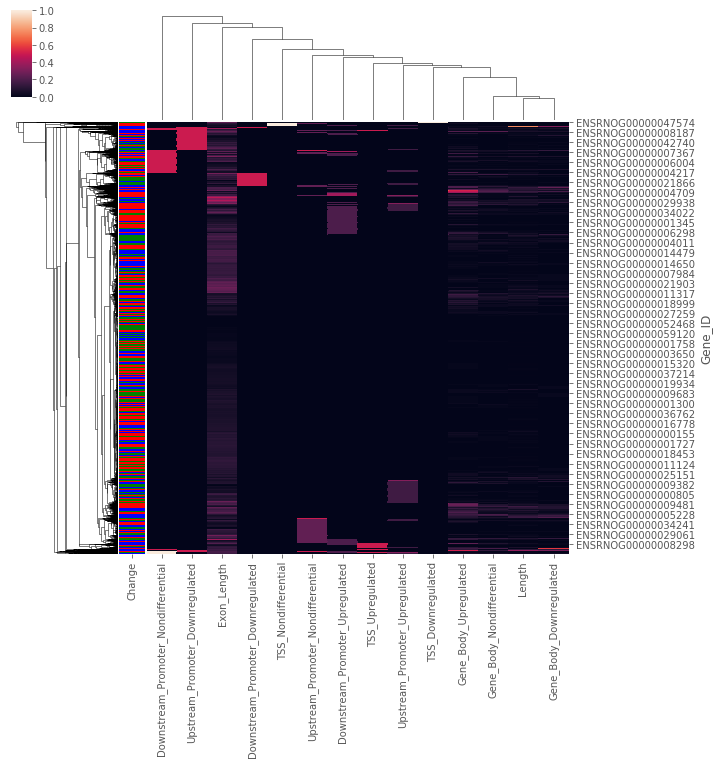

In [33]:
heatmap = sns.clustermap(SC_cAMP_cleaned_dataset[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]],
                         standard_scale=1, row_colors =row_colors) #, yticklabels=True, 
#plt.colorbar(heatmap)

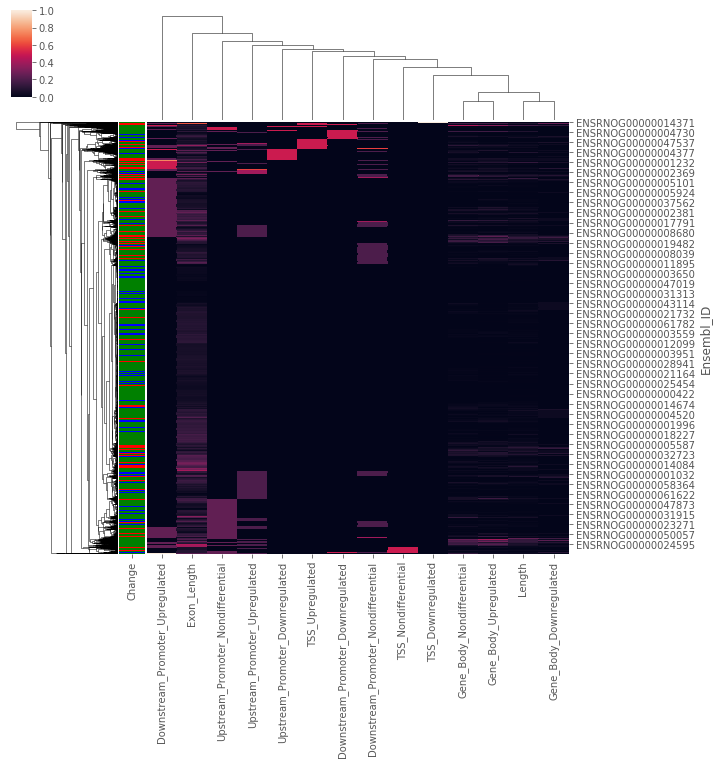

In [34]:

region_colors = {"Downregulated": 'b', "Nondifferential": 'g', "Upregulated":'r'}
row_colors=SC_VitC_cleaned_dataset[["Change"]].T.squeeze().map(region_colors)
heatmap = sns.clustermap(SC_VitC_cleaned_dataset[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]],
                         standard_scale=1, row_colors =row_colors) #, yticklabels=True, 

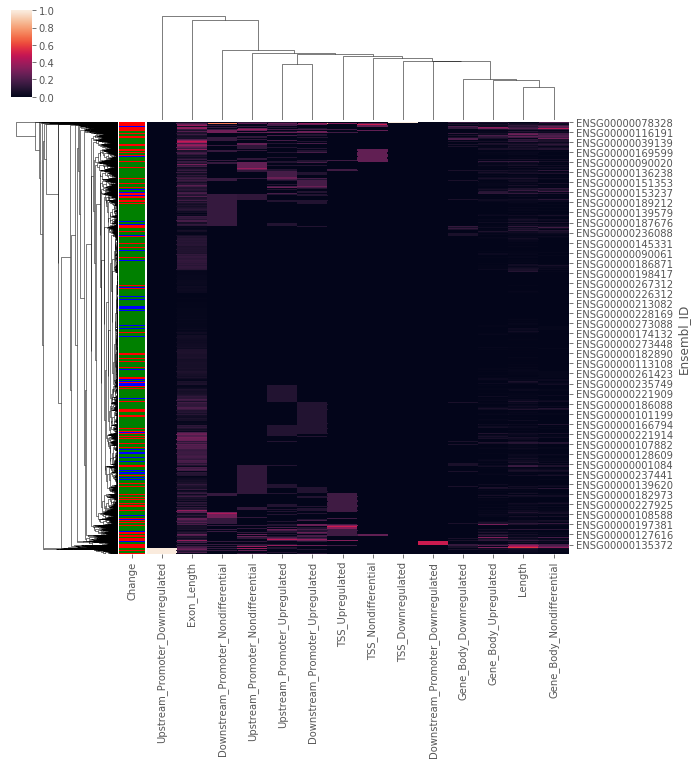

In [35]:
region_colors = {"Downregulated": 'b', "Nondifferential": 'g', "Upregulated":'r'}
row_colors=ARPE_cleaned_dataset[["Change"]].T.squeeze().map(region_colors)
heatmap = sns.clustermap(ARPE_cleaned_dataset[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]],
                         standard_scale=1, row_colors =row_colors) #, yticklabels=True, 

Wow. These heatmaps are surprisingly useless. Something tells me that heirarchal clustering isn't going to give very useful results, because the clustering here I believe uses Euclidean distances and ward clustering.  

In [36]:
#ARPE_cleaned_dataset.head()
ARPE_Normalized = pd.DataFrame(scale(ARPE_cleaned_dataset[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]]))
ARPE_Normalized.columns = ["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]
Ensembl_ID = ARPE_cleaned_dataset.index.values
ARPE_Normalized["Ensembl_ID"] = Ensembl_ID
ARPE_Normalized = ARPE_Normalized.set_index("Ensembl_ID")
Change = ARPE_cleaned_dataset["Change"].values
ARPE_Normalized["Change"] = Change




In [37]:
ARPE_pca_model = PCA()
ARPE_PCA = ARPE_pca_model.fit_transform(ARPE_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]])

ARPE_PCA_dataframe = pd.DataFrame(ARPE_PCA)
Ensembl_ID = ARPE_Normalized.index.values
ARPE_PCA_dataframe["Ensembl_ID"] = Ensembl_ID
ARPE_PCA_dataframe = ARPE_PCA_dataframe.set_index("Ensembl_ID")
change = ARPE_Normalized["Change"].values
ARPE_PCA_dataframe["Change"] = change
ARPE_PCA_dataframe.columns = ["PC_1", "PC_2", "PC_3", "PC_4", "PC_5", "PC_6", "PC_7", "PC_8", 
                              "PC_9", "PC_10", "PC_11", "PC_12", "PC_13", "PC_14", "Region"]

In [38]:
ARPE_PCA_dataframe.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,Region
Ensembl_ID,,,,,,,,,,,,,,,
ENSG00000000003,-0.640045,-0.188427,1.841298,0.937859,-1.991830,-1.449293,2.178476,-1.399587,0.249624,0.664050,0.088379,-0.116272,0.082418,0.024484,Downregulated
ENSG00000000419,-1.216522,0.405485,-0.292359,-0.034832,-0.047796,0.003209,0.234372,0.149249,-0.001175,-0.210136,0.333212,-0.014403,0.038124,0.134485,Nondifferential
ENSG00000000457,-0.498389,0.428928,-0.093635,-0.019118,0.010013,0.036167,-0.543828,-0.761906,-0.005122,0.856184,-0.115758,0.006017,0.163658,-0.062453,Nondifferential
ENSG00000000460,-0.197492,0.752827,-0.276014,-0.050884,-0.025533,-0.001420,-0.204509,-0.388151,-0.006659,0.397217,0.355010,-0.003425,0.058289,-0.559625,Nondifferential
ENSG00000000971,-0.243824,0.222818,0.736689,0.071910,-0.185251,-0.181850,-0.998903,0.188153,-1.340648,-0.032990,0.119017,-0.142756,-0.332307,0.112196,Upregulated


In [39]:
ARPE_PCA_dataframe.describe()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14
count,1.459900e+04,1.459900e+04,1.459900e+04,1.459900e+04,1.459900e+04,1.459900e+04,1.459900e+04,1.459900e+04,1.459900e+04,1.459900e+04,1.459900e+04,1.459900e+04,1.459900e+04,1.459900e+04
mean,3.841407e-16,-6.039951e-16,2.663653e-16,3.291685e-17,6.373098e-17,-7.343433e-17,-1.149863e-16,3.495693e-16,1.160479e-17,3.576532e-17,-5.153694e-17,3.546778e-17,-1.558221e-17,-2.759017e-17
std,1.806492e+00,1.306421e+00,1.044245e+00,1.003600e+00,9.953809e-01,9.909289e-01,9.373290e-01,9.197283e-01,9.008471e-01,8.736783e-01,7.635799e-01,7.307848e-01,5.879974e-01,4.452621e-01
min,-1.501928e+00,-1.558115e+01,-7.174035e+00,-5.327275e+00,-8.463066e+00,-6.960947e+00,-6.141350e+00,-6.685728e+00,-5.591312e+00,-8.250529e+00,-1.294496e+01,-5.994752e+00,-9.232763e+00,-6.922468e+00
25%,-1.092052e+00,-4.468594e-01,-4.186781e-01,-9.794473e-02,-6.872465e-02,-6.081370e-03,-4.601217e-01,-4.346429e-01,-1.572787e-01,-4.057638e-01,-2.492072e-01,-8.967822e-02,-1.318437e-01,-9.276605e-02
50%,-5.358894e-01,3.064409e-01,-2.286133e-01,-2.259998e-02,-3.830576e-02,1.349446e-02,7.615917e-02,2.418671e-02,-2.253344e-03,-1.457567e-01,9.768557e-02,-8.219752e-03,4.067841e-02,-4.283682e-03
75%,3.959158e-01,4.107964e-01,1.836483e-01,1.496653e-02,2.850447e-02,9.483666e-02,3.299089e-01,3.201594e-01,1.597064e-02,3.300189e-01,2.669725e-01,8.000764e-02,1.340817e-01,1.034892e-01
max,1.978749e+01,2.050038e+01,1.366976e+01,1.741669e+01,1.057897e+01,1.544701e+01,7.323928e+00,8.150264e+00,6.782169e+00,8.887776e+00,1.341782e+01,6.338919e+00,9.875085e+00,7.161483e+00


In [40]:
cmap_bold = ListedColormap(['lime', 'blue', 'red' ]) #, 'magenta', 'aqua', 'green', 'yellow', 'orange'

In [41]:
ARPE_dictionary = dict([(y,x+1) for x,y in enumerate(sorted(set(ARPE_Normalized["Change"].values)))])
ARPE_map_colors = [ARPE_dictionary[x] for x in ARPE_Normalized["Change"].values]


In [42]:
ARPE_dictionary

{'Downregulated': 1, 'Nondifferential': 2, 'Upregulated': 3}

In [43]:
ARPE_PCA_dataframe.to_csv("ARPE.pca.csv")

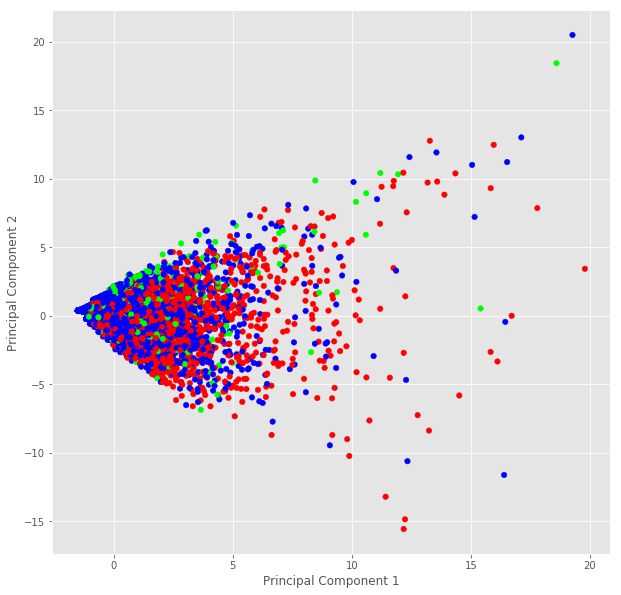

In [44]:
plt.scatter(ARPE_PCA_dataframe["PC_1"], ARPE_PCA_dataframe["PC_2"],s=30, c=ARPE_map_colors, cmap = cmap_bold)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig(output_path+"ARPE_PCA.png", dpi=300) # size above specified at 10x6
plt.show()

[0.23308502 0.12190134 0.07788377 0.07193889 0.07076538 0.07013377
 0.06275182 0.06041731 0.05796214 0.05451868 0.04164388 0.03814356
 0.02469409 0.01416034]


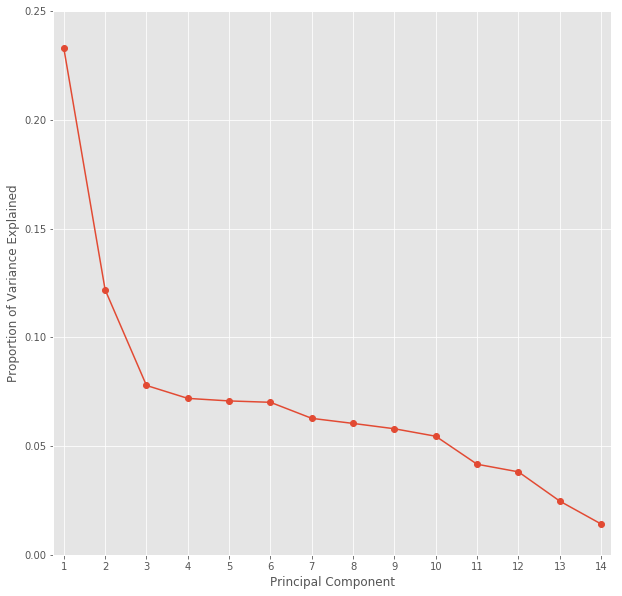

In [45]:
var_ratio = ARPE_pca_model.explained_variance_ratio_
print(var_ratio)

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14], var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,14.25)
plt.ylim(0,0.25)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
plt.show()

Apparently, at least for the APRE dataset, the first two principal components only account for about 35% of the total variance, indicating that this is not such a good choice of mapping clusters. Oh well. This is what I can do for now. 

In [46]:
# SC_cAMP_cleaned_dataset.head()
SC_cAMP_Normalized = pd.DataFrame(scale(SC_cAMP_cleaned_dataset[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]]))
SC_cAMP_Normalized.columns = ["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]
Ensembl_ID = SC_cAMP_cleaned_dataset.index.values
SC_cAMP_Normalized["Ensembl_ID"] = Ensembl_ID
SC_cAMP_Normalized = SC_cAMP_Normalized.set_index("Ensembl_ID")
Change = SC_cAMP_cleaned_dataset["Change"].values
SC_cAMP_Normalized["Change"] = Change



/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys


In [47]:
#SC_cAMP_cleaned_dataset
SC_cAMP_pca_model = PCA()
SC_cAMP_PCA = SC_cAMP_pca_model.fit_transform(SC_cAMP_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]])

SC_cAMP_PCA_dataframe = pd.DataFrame(SC_cAMP_PCA)
Ensembl_ID = SC_cAMP_Normalized.index.values
SC_cAMP_PCA_dataframe["Ensembl_ID"] = Ensembl_ID
SC_cAMP_PCA_dataframe = SC_cAMP_PCA_dataframe.set_index("Ensembl_ID")
change = SC_cAMP_Normalized["Change"].values
SC_cAMP_PCA_dataframe["Change"] = change
SC_cAMP_PCA_dataframe.columns = ["PC_1", "PC_2", "PC_3", "PC_4", "PC_5", "PC_6", "PC_7", "PC_8", 
                              "PC_9", "PC_10", "PC_11", "PC_12", "PC_13", "PC_14", "Region"]

In [48]:
SC_cAMP_dictionary = dict([(y,x+1) for x,y in enumerate(sorted(set(SC_cAMP_Normalized["Change"].values)))])
SC_cAMP_map_colors = [SC_cAMP_dictionary[x] for x in SC_cAMP_Normalized["Change"].values]
SC_cAMP_dictionary

{'Downregulated': 1, 'Nondifferential': 2, 'Upregulated': 3}

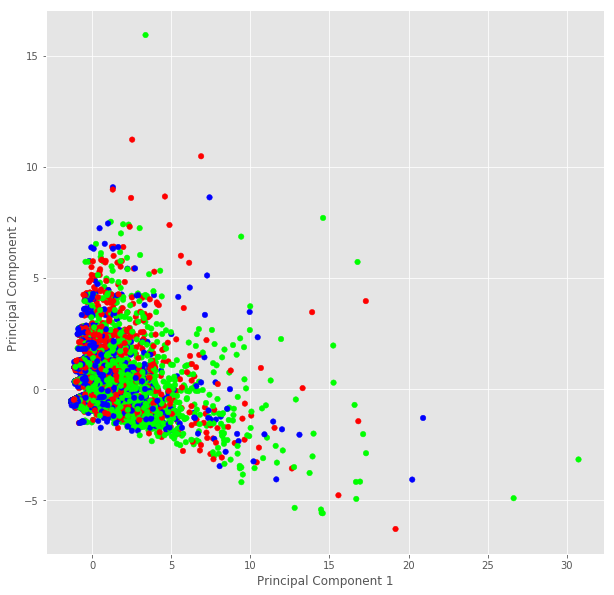

In [49]:
plt.scatter(SC_cAMP_PCA_dataframe["PC_1"], SC_cAMP_PCA_dataframe["PC_2"],s=30, c=SC_cAMP_map_colors, cmap = cmap_bold)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig(output_path+"SC_cAMP_PCA.png", dpi=300) # size above specified at 10x6
plt.show()

[0.22916531 0.08893903 0.07569215 0.07285113 0.0725561  0.07068519
 0.06997248 0.06726886 0.06628743 0.05999614 0.05813335 0.03738319
 0.01929941 0.01177024]


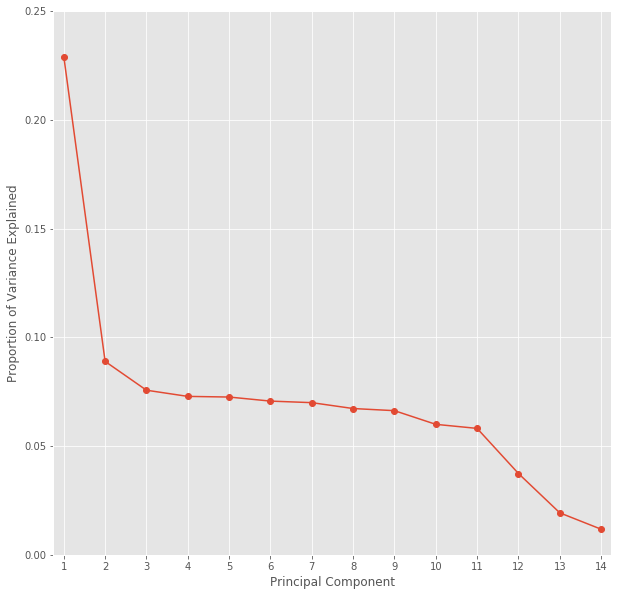

In [50]:
var_ratio = SC_cAMP_pca_model.explained_variance_ratio_
print(var_ratio)

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14], var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,14.25)
plt.ylim(0,0.25)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
plt.show()

In [51]:
# SC_VitC_cleaned_dataset.head()
SC_VitC_Normalized = pd.DataFrame(scale(SC_VitC_cleaned_dataset[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]]))
SC_VitC_Normalized.columns = ["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]
Ensembl_ID = SC_VitC_cleaned_dataset.index.values
SC_VitC_Normalized["Ensembl_ID"] = Ensembl_ID
SC_VitC_Normalized = SC_VitC_Normalized.set_index("Ensembl_ID")
Change = SC_VitC_cleaned_dataset["Change"].values
SC_VitC_Normalized["Change"] = Change



/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys


In [52]:
#SC_VitC_cleaned_dataset
SC_VitC_pca_model = PCA()
SC_VitC_PCA = SC_VitC_pca_model.fit_transform(SC_VitC_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                                  "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                                 "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                                                 "Downstream_Promoter_Nondifferential", "TSS_Nondifferential",
                                                 "Gene_Body_Upregulated", "Upstream_Promoter_Upregulated", 
                                                 "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]])

SC_VitC_PCA_dataframe = pd.DataFrame(SC_VitC_PCA)
Ensembl_ID = SC_VitC_Normalized.index.values
SC_VitC_PCA_dataframe["Ensembl_ID"] = Ensembl_ID
SC_VitC_PCA_dataframe = SC_VitC_PCA_dataframe.set_index("Ensembl_ID")
change = SC_VitC_Normalized["Change"].values
SC_VitC_PCA_dataframe["Change"] = change
SC_VitC_PCA_dataframe.columns = ["PC_1", "PC_2", "PC_3", "PC_4", "PC_5", "PC_6", "PC_7", "PC_8", 
                              "PC_9", "PC_10", "PC_11", "PC_12", "PC_13", "PC_14", "Region"]

In [53]:
SC_VitC_dictionary = dict([(y,x+1) for x,y in enumerate(sorted(set(SC_VitC_Normalized["Change"].values)))])
SC_VitC_map_colors = [SC_VitC_dictionary[x] for x in SC_VitC_Normalized["Change"].values]
SC_VitC_dictionary

{'Downregulated': 1, 'Nondifferential': 2, 'Upregulated': 3}

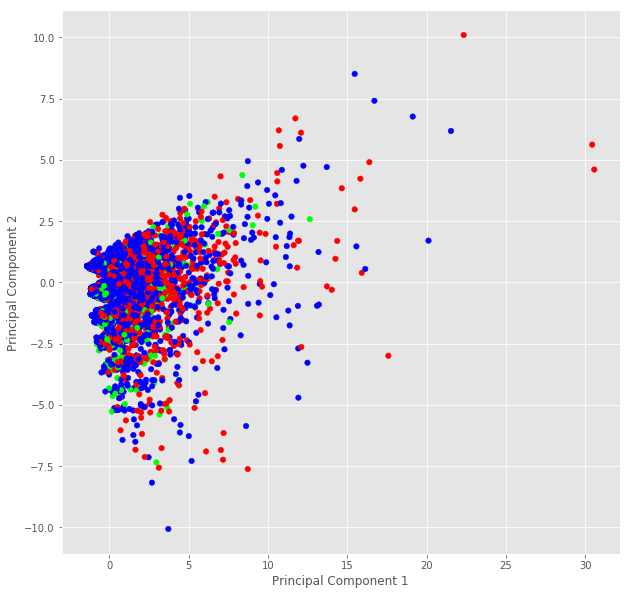

In [54]:
plt.scatter(SC_VitC_PCA_dataframe["PC_1"], SC_VitC_PCA_dataframe["PC_2"],s=30, c=SC_VitC_map_colors, cmap = cmap_bold)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig(output_path+"SC_VitC_PCA.png", dpi=300) # size above specified at 10x6
plt.show()

[0.23729438 0.0921251  0.07523809 0.07340828 0.07149577 0.07080737
 0.06909645 0.06829333 0.06495064 0.05891984 0.05296086 0.03958761
 0.01668656 0.00913572]


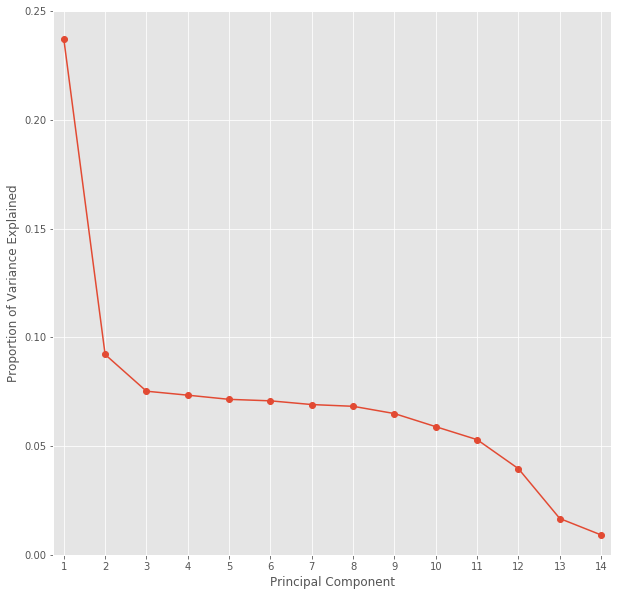

In [55]:
var_ratio = SC_VitC_pca_model.explained_variance_ratio_
print(var_ratio)

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14], var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,14.25)
plt.ylim(0,0.25)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
plt.show()

According to these, the first two principle components account for about 35% of the variability. This is not great. It looks like it would be best to include about 10-12 principle components. I can't graph that, but I think I am going to graph clustering on the first two PCAs just because that way I can see it on a graph. 

In [56]:
ARPE_Normalized.head()

,Length,Exon_Length,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,Downstream_Promoter_Downregulated,TSS_Downregulated,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,Downstream_Promoter_Nondifferential,TSS_Nondifferential,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Downstream_Promoter_Upregulated,TSS_Upregulated,Change
Ensembl_ID,,,,,,,,,,,,,,,
ENSG00000000003,-0.459008,0.111174,-0.243516,-0.11298,-0.103286,-0.051755,-0.434994,-0.423382,-0.414895,4.062426,-0.392168,-0.452456,-0.469535,-0.29699,Downregulated
ENSG00000000419,-0.339981,-0.807101,-0.243516,-0.11298,-0.103286,-0.051755,-0.434994,-0.423382,-0.414895,-0.211054,-0.185793,-0.452456,-0.469535,-0.29699,Nondifferential
ENSG00000000457,-0.160628,1.006100,-0.243516,-0.11298,-0.103286,-0.051755,-0.170512,-0.423382,-0.414895,-0.211054,-0.185793,-0.452456,-0.469535,-0.29699,Nondifferential
ENSG00000000460,-0.035890,0.305980,-0.243516,-0.11298,-0.103286,-0.051755,0.622934,-0.423382,-0.414895,-0.211054,0.020582,-0.452456,-0.469535,-0.29699,Nondifferential
ENSG00000000971,0.285342,0.226524,-0.243516,-0.11298,-0.103286,-0.051755,-0.170512,-0.423382,1.604796,-0.211054,-0.392168,-0.452456,-0.469535,-0.29699,Upregulated


In [57]:
# ARPE_Normalized
# ks = range(1,100)
# ARPE_Kmeans_scores = []

# for k in ks:
#     model = KMeans(n_clusters=k)
#     model.fit_predict(ARPE_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
#                                        "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
#                                        "TSS_Downregulated", "Gene_Body_Nondifferential", 
#                                        "Upstream_Promoter_Nondifferential","Downstream_Promoter_Nondifferential", 
#                                        "TSS_Nondifferential","Gene_Body_Upregulated", "Upstream_Promoter_Upregulated",
#                                        "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]])
#     ARPE_Kmeans_scores.append(-model.score(ARPE_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
#                                        "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
#                                        "TSS_Downregulated", "Gene_Body_Nondifferential", 
#                                        "Upstream_Promoter_Nondifferential","Downstream_Promoter_Nondifferential", 
#                                        "TSS_Nondifferential","Gene_Body_Upregulated", "Upstream_Promoter_Upregulated",
#                                        "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]]))

# plt.plot(ks, ARPE_Kmeans_scores)
# plt.ylabel('total intra-cluster distance')
# plt.xlabel('k')
# plt.show()

This took a long time to generate, so I am going to save it as a csv file and then I can read it in again as a list when I rerun the entire notebook. Anyways, this appears to have an elbow point around 9 to 18.

In [58]:
# with open(output_path+'ARPE_Kmeans_scores.csv', 'w') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerow(ARPE_Kmeans_scores)

In [59]:
with open(output_path+'ARPE_Kmeans_scores.csv', 'r') as myfile:
    reader = csv.reader(myfile)
    ARPE_Kmeans_scores = list(reader)
ARPE_Kmeans_scores = [float(i) for i in ARPE_Kmeans_scores[0]]

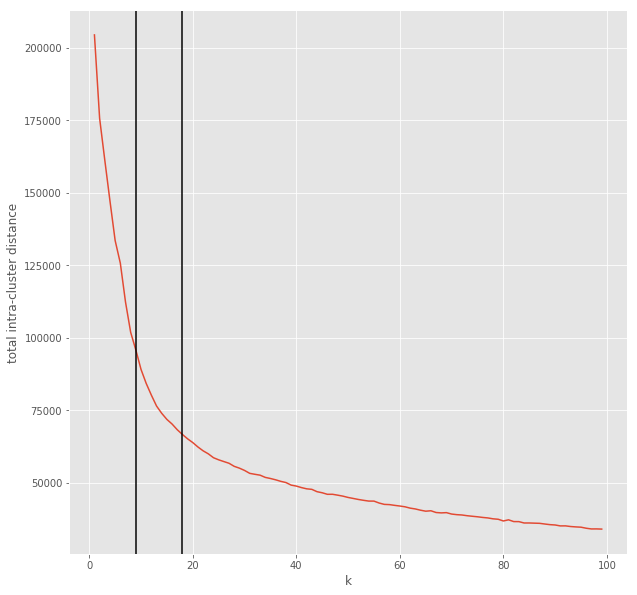

In [60]:
ks = range(1,100)
plt.plot(ks, ARPE_Kmeans_scores)
plt.ylabel('total intra-cluster distance')
plt.xlabel('k')
plt.axvline(x=9, color='k')
plt.axvline(x=18, color='k')
plt.show()

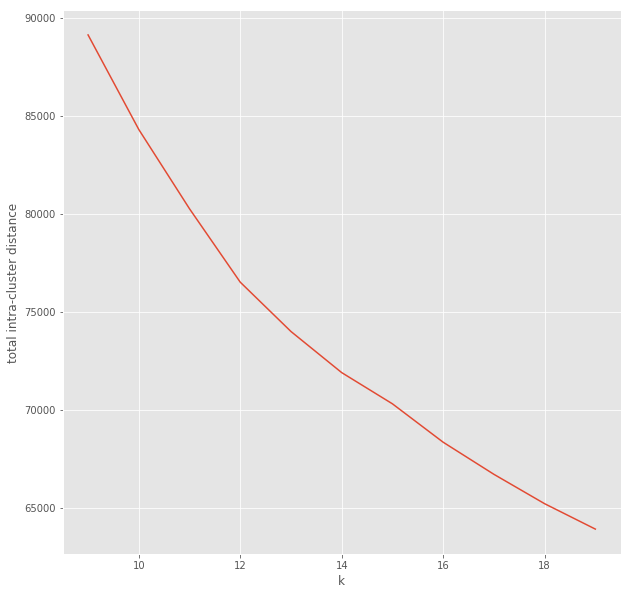

In [61]:
#tmp = [float(i) for i in ARPE_Kmeans_scores[0][9:20]]
tmp = ARPE_Kmeans_scores[9:20]
plt.plot(range(9,20), tmp)
plt.ylabel('total intra-cluster distance')
plt.xlabel('k')
plt.show()

For n_clusters = 9 The silhouette_score is : 0.3367833444761818


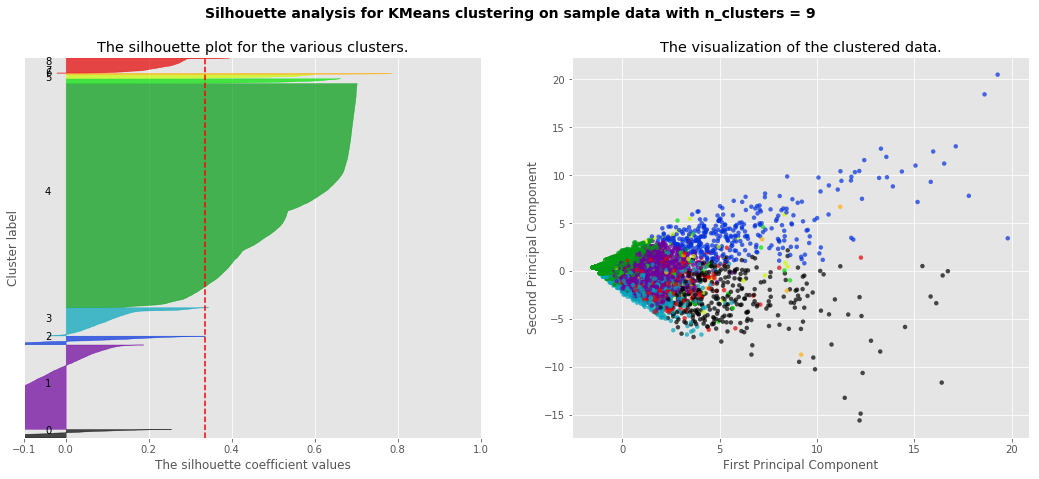

For n_clusters = 10 The silhouette_score is : 0.3373327708320088


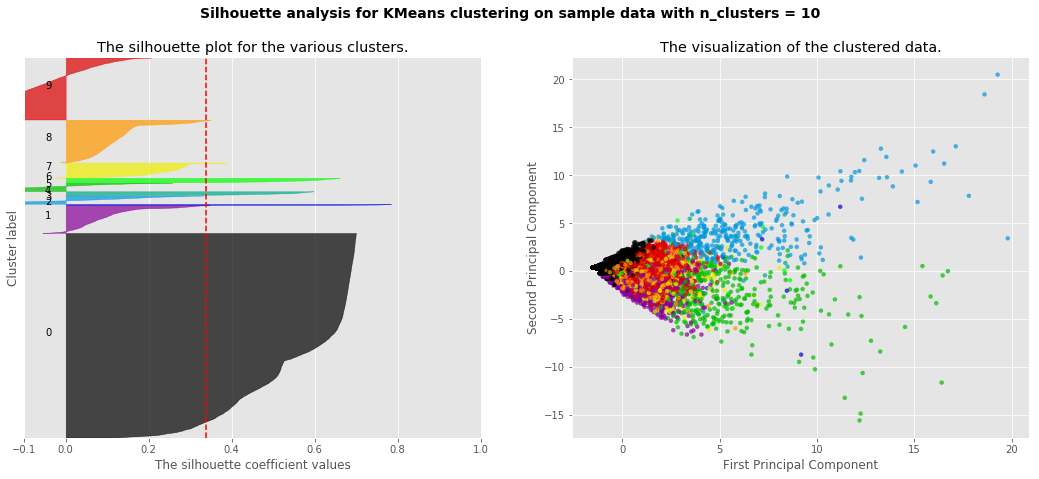

For n_clusters = 11 The silhouette_score is : 0.34848550970144787


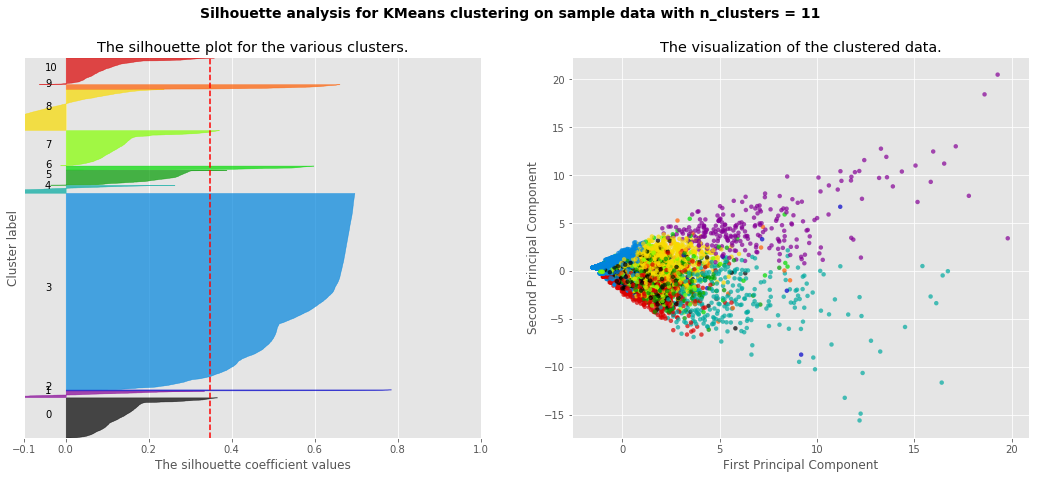

For n_clusters = 12 The silhouette_score is : 0.3265111851847965


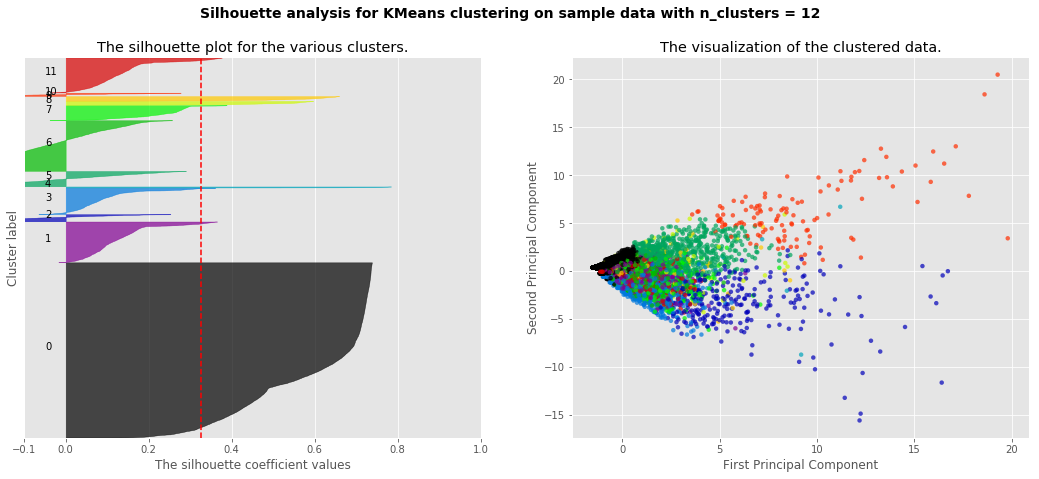

For n_clusters = 13 The silhouette_score is : 0.3347890587872974


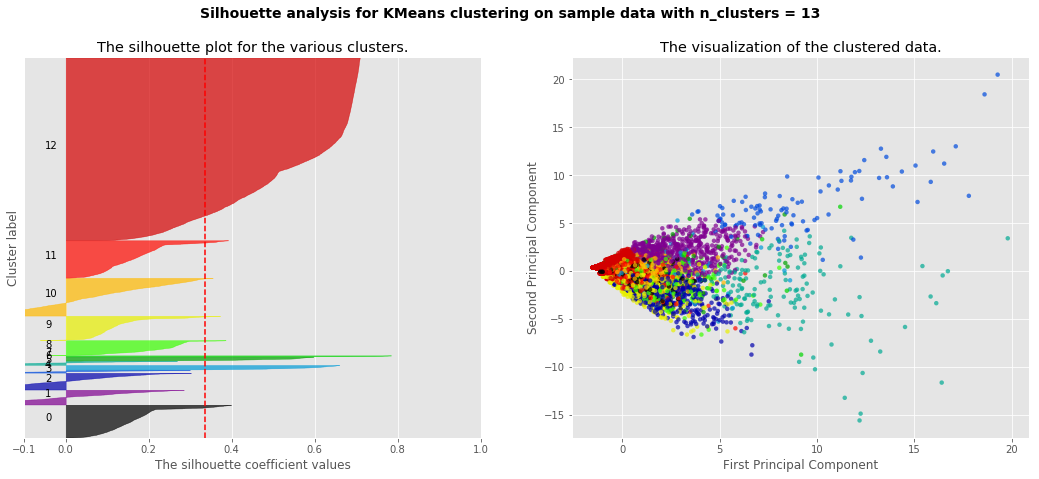

For n_clusters = 14 The silhouette_score is : 0.3407414912887633


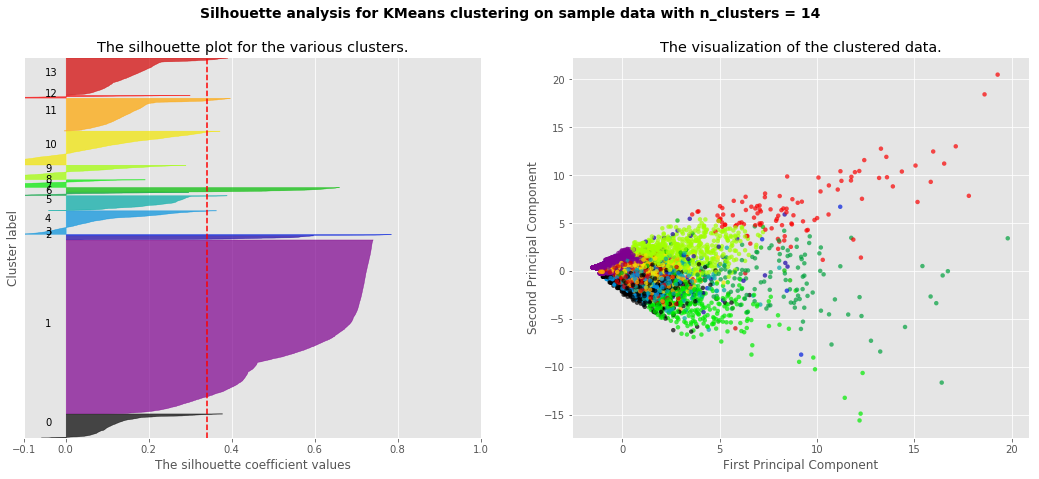

For n_clusters = 15 The silhouette_score is : 0.3178406883577228


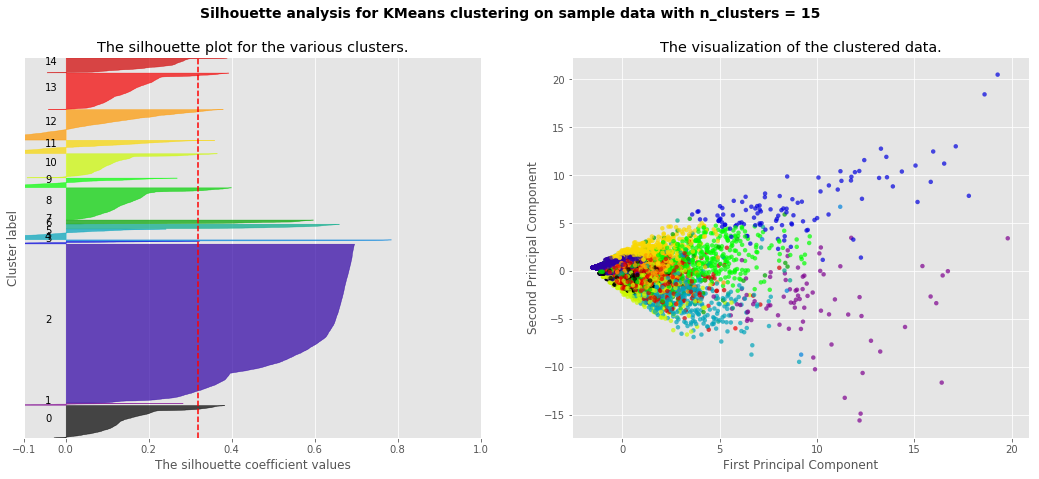

For n_clusters = 16 The silhouette_score is : 0.32087911123301704


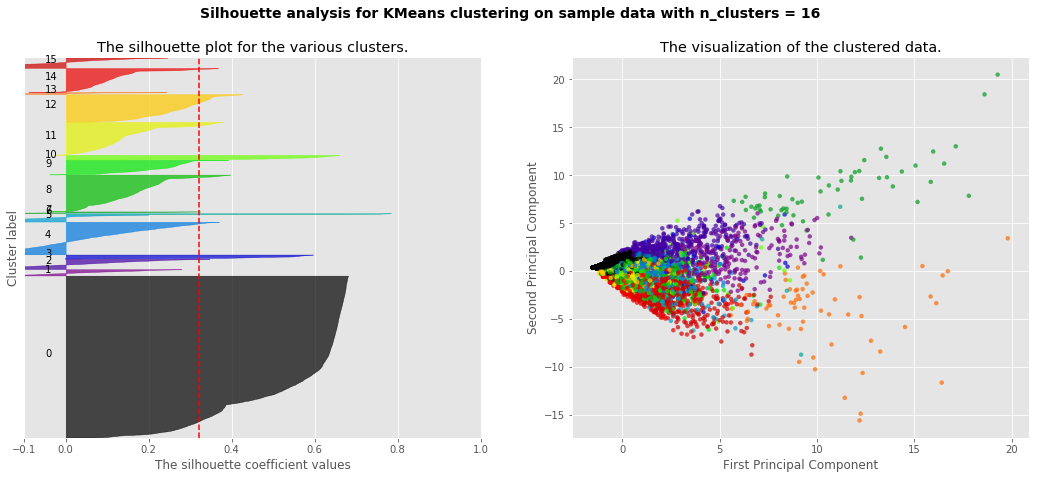

For n_clusters = 17 The silhouette_score is : 0.3238626162272631


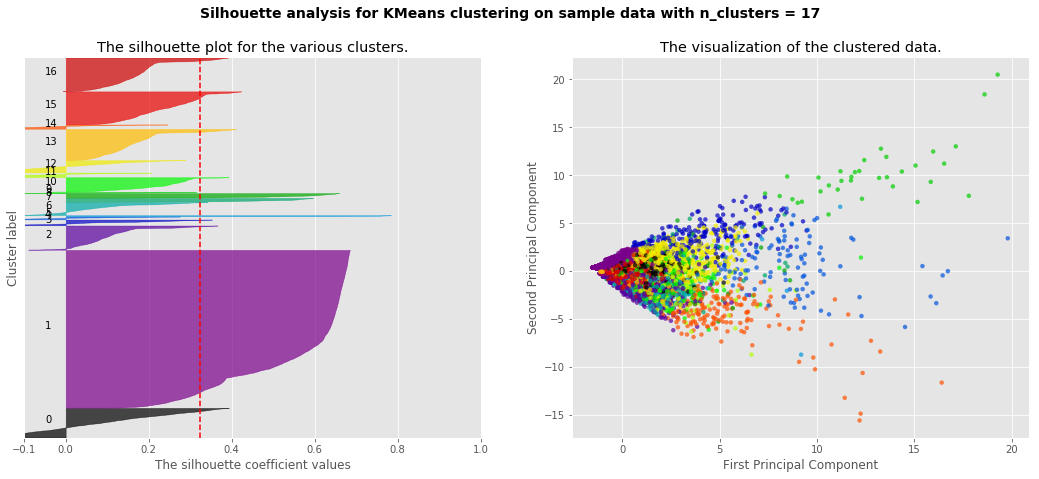

For n_clusters = 18 The silhouette_score is : 0.2753763759084766


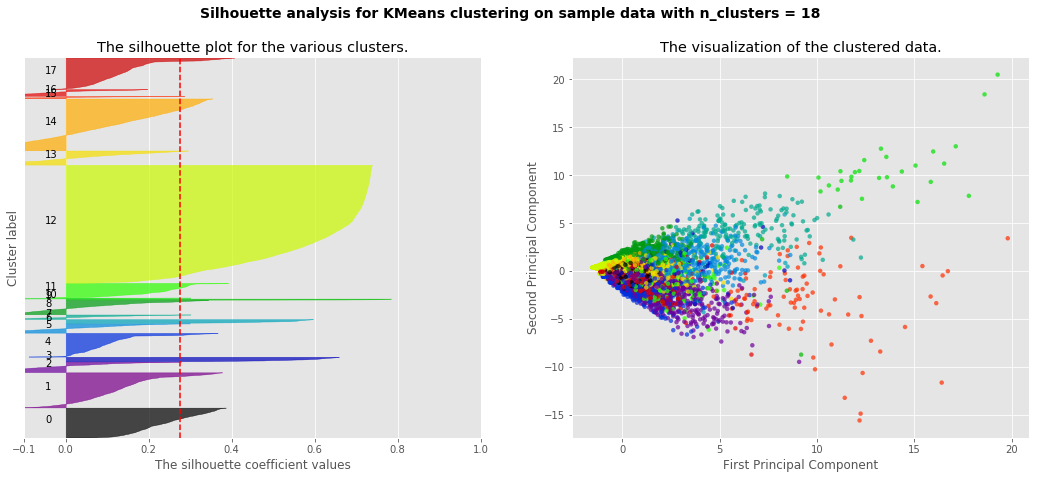

For n_clusters = 19 The silhouette_score is : 0.2782951283239767


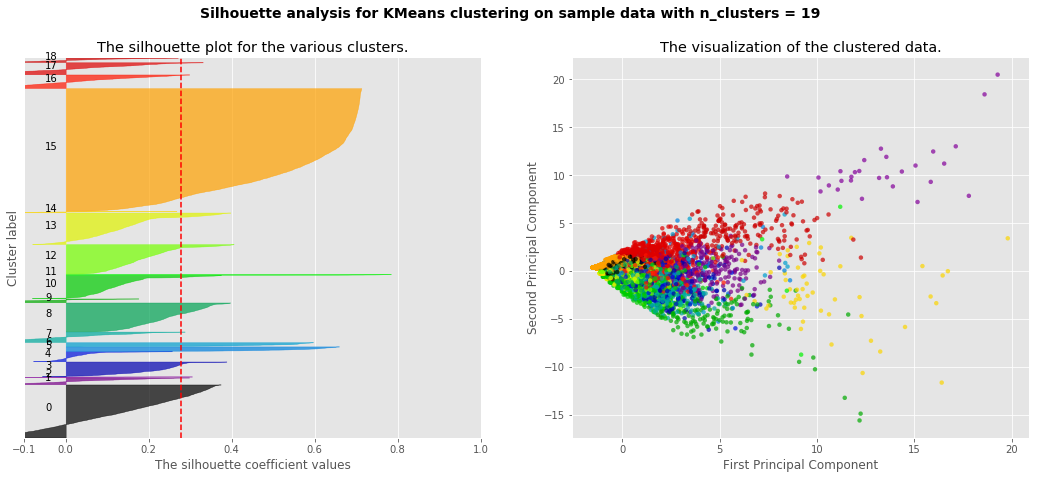

For n_clusters = 20 The silhouette_score is : 0.3349731265414626


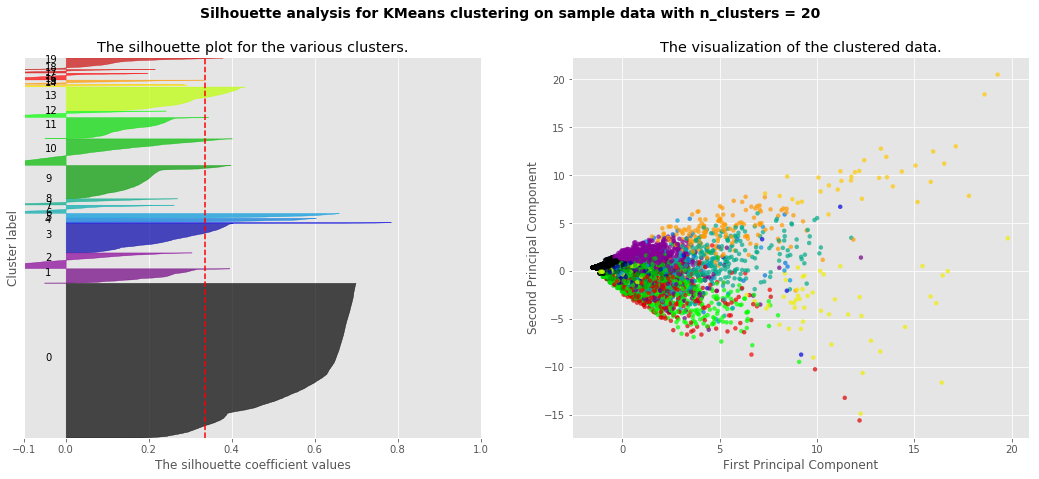

In [62]:
# 2. Vary k and find the best value. Describe wow do you determine best?
range_n_clusters = [9,10,11,12,13,14,15,16,17,18,19,20]

average_silhouette_scores = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(ARPE_Normalized) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(ARPE_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                        "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                        "TSS_Downregulated", "Gene_Body_Nondifferential", 
                                        "Upstream_Promoter_Nondifferential","Downstream_Promoter_Nondifferential", 
                                        "TSS_Nondifferential","Gene_Body_Upregulated", "Upstream_Promoter_Upregulated",
                                        "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(ARPE_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                        "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                        "TSS_Downregulated", "Gene_Body_Nondifferential", 
                                        "Upstream_Promoter_Nondifferential","Downstream_Promoter_Nondifferential", 
                                        "TSS_Nondifferential","Gene_Body_Upregulated", "Upstream_Promoter_Upregulated",
                                        "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]], cluster_labels)
    average_silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(ARPE_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                        "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                        "TSS_Downregulated", "Gene_Body_Nondifferential", 
                                        "Upstream_Promoter_Nondifferential","Downstream_Promoter_Nondifferential", 
                                        "TSS_Nondifferential","Gene_Body_Upregulated", "Upstream_Promoter_Upregulated",
                                        "Downstream_Promoter_Upregulated", "TSS_Upregulated"]], cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette coefficient of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    
    #plt.scatter(violence_PCA_dataframe["PC_1"], violence_PCA_dataframe["PC_2"],s=60, c=y_pred, cmap = cmap_bold)

    ax2.scatter(ARPE_PCA_dataframe["PC_1"], ARPE_PCA_dataframe["PC_2"], marker='.', s=80, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #            c="white", alpha=1, s=400, edgecolor='k')

    #for i, c in enumerate(centers):
    #    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                s=50, edgecolor='k')
    # This doesn't work because I am plotting the PCA's, not the dimensions that were used to calculate silhouette scores
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("First Principal Component")
    ax2.set_ylabel("Second Principal Component")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
    plt.savefig(output_path+"ARPE_Kmeans_Silhouette_charts/ARPE_Silhouette_Scores_K_Means_"+str(n_clusters)+"_clusters.png", dpi=300) # size above specified at 10x6
    plt.show()

In [63]:
ARPE_silhouette_scores = pd.DataFrame({'K': range_n_clusters, 'Silhouette_Score': average_silhouette_scores})
ARPE_silhouette_scores.to_csv(output_path+"ARPE_Kmeans_Silhouette_charts/ARPE_Silhouette_Scores.csv")

It looks to me like it is best at 11, 14, 17, and 20. I find it odd that this line didn't go straight in a row. I am going to only do this for the ARPE dataset because it was time consuming, but I will proceed with 14 clusters because it looks like an appropriate point for and elbow and it has a regional silhouette maximum.

In [64]:
ARPE_y_pred = list(KMeans(n_clusters=14, max_iter=10).fit_predict(ARPE_Normalized[["Length", "Exon_Length", "Gene_Body_Downregulated", 
                                       "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated", 
                                       "TSS_Downregulated", "Gene_Body_Nondifferential", 
                                       "Upstream_Promoter_Nondifferential","Downstream_Promoter_Nondifferential", 
                                       "TSS_Nondifferential","Gene_Body_Upregulated", "Upstream_Promoter_Upregulated",
                                       "Downstream_Promoter_Upregulated", "TSS_Upregulated" ]]))
ARPE_Normalized["Group_K_Means"] = ARPE_y_pred

In [65]:
#expressed_genes_info.groupby(["Biotype"], as_index = False).size()
ARPE_Normalized.groupby(["Group_K_Means"]).size()

Group_K_Means
0     1247
1      200
2     6376
3      416
4      152
5     1418
6     1253
7       39
8      177
9      953
10     572
11      37
12    1231
13     528
dtype: int64

In [66]:
ARPE_Normalized.head()

,Length,Exon_Length,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,Downstream_Promoter_Downregulated,TSS_Downregulated,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,Downstream_Promoter_Nondifferential,TSS_Nondifferential,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Downstream_Promoter_Upregulated,TSS_Upregulated,Change,Group_K_Means
Ensembl_ID,,,,,,,,,,,,,,,,
ENSG00000000003,-0.459008,0.111174,-0.243516,-0.11298,-0.103286,-0.051755,-0.434994,-0.423382,-0.414895,4.062426,-0.392168,-0.452456,-0.469535,-0.29699,Downregulated,10
ENSG00000000419,-0.339981,-0.807101,-0.243516,-0.11298,-0.103286,-0.051755,-0.434994,-0.423382,-0.414895,-0.211054,-0.185793,-0.452456,-0.469535,-0.29699,Nondifferential,2
ENSG00000000457,-0.160628,1.006100,-0.243516,-0.11298,-0.103286,-0.051755,-0.170512,-0.423382,-0.414895,-0.211054,-0.185793,-0.452456,-0.469535,-0.29699,Nondifferential,12
ENSG00000000460,-0.035890,0.305980,-0.243516,-0.11298,-0.103286,-0.051755,0.622934,-0.423382,-0.414895,-0.211054,0.020582,-0.452456,-0.469535,-0.29699,Nondifferential,2
ENSG00000000971,0.285342,0.226524,-0.243516,-0.11298,-0.103286,-0.051755,-0.170512,-0.423382,1.604796,-0.211054,-0.392168,-0.452456,-0.469535,-0.29699,Upregulated,5


In [67]:
cmap_bold = ListedColormap(['lime', 'blue', 'black', 'red', 'magenta', 'aqua', 'green', 
                            'orange', 'purple', 'white', 'deeppink', 'yellow',  'lightblue', 'darkgoldenrod']) 

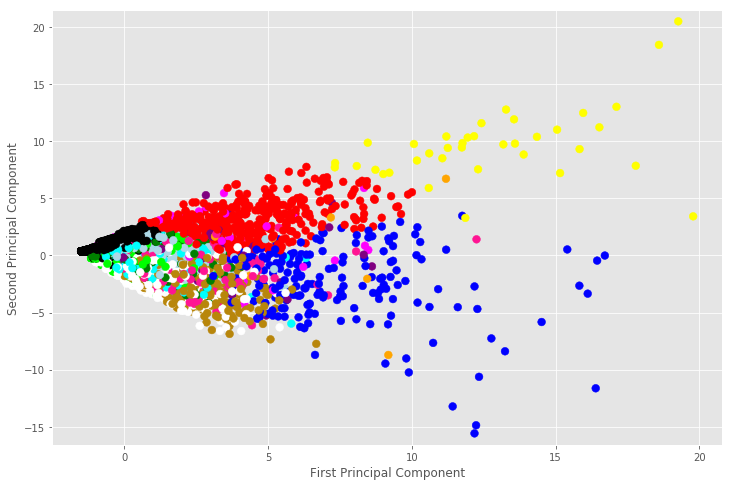

In [68]:
plt.rcParams['figure.figsize'] = (12, 8)
fig,ax1 = plt.subplots()

ax1.set_xlim(ARPE_PCA_dataframe["PC_1"].min()-1,ARPE_PCA_dataframe["PC_1"].max()+1)
ax1.set_ylim(ARPE_PCA_dataframe["PC_2"].min()-1,ARPE_PCA_dataframe["PC_2"].max()+1)

# Plot Principal Components 1 and 2
#for i,name in enumerate(ARPE_PCA_dataframe.index.values):
#    ax1.annotate(name, (ARPE_PCA_dataframe.iloc[i,0], ARPE_PCA_dataframe.iloc[i,1]), ha='center',fontsize=16)
plt.scatter(ARPE_PCA_dataframe["PC_1"], ARPE_PCA_dataframe["PC_2"],s=60, c=ARPE_y_pred, cmap = cmap_bold)
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.savefig(output_path+"ARPE_Kmeans_clusters_PCA.png", dpi=300) # size above specified at 10x6
plt.show()

Well, it certainly comes up with clusters. I would never have guessed them based on the PCA, but I think this is interesting that they actually have clusters. I wonder if the huge cluster is ones that have almost not 5hmC peaks.

In [69]:
ARPE_DBSCAN_input = ARPE_Normalized[['Length', 'Exon_Length', 'Gene_Body_Downregulated',
                                     'Upstream_Promoter_Downregulated',
                                     'Downstream_Promoter_Downregulated', 'TSS_Downregulated',
                                     'Gene_Body_Nondifferential', 'Upstream_Promoter_Nondifferential',
                                     'Downstream_Promoter_Nondifferential', 'TSS_Nondifferential',
                                     'Gene_Body_Upregulated', 'Upstream_Promoter_Upregulated',
                                     'Downstream_Promoter_Upregulated', 'TSS_Upregulated']]

In [70]:
ARPE_DBSCAN_input.head()

,Length,Exon_Length,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,Downstream_Promoter_Downregulated,TSS_Downregulated,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,Downstream_Promoter_Nondifferential,TSS_Nondifferential,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Downstream_Promoter_Upregulated,TSS_Upregulated
Ensembl_ID,,,,,,,,,,,,,,
ENSG00000000003,-0.459008,0.111174,-0.243516,-0.11298,-0.103286,-0.051755,-0.434994,-0.423382,-0.414895,4.062426,-0.392168,-0.452456,-0.469535,-0.29699
ENSG00000000419,-0.339981,-0.807101,-0.243516,-0.11298,-0.103286,-0.051755,-0.434994,-0.423382,-0.414895,-0.211054,-0.185793,-0.452456,-0.469535,-0.29699
ENSG00000000457,-0.160628,1.006100,-0.243516,-0.11298,-0.103286,-0.051755,-0.170512,-0.423382,-0.414895,-0.211054,-0.185793,-0.452456,-0.469535,-0.29699
ENSG00000000460,-0.035890,0.305980,-0.243516,-0.11298,-0.103286,-0.051755,0.622934,-0.423382,-0.414895,-0.211054,0.020582,-0.452456,-0.469535,-0.29699
ENSG00000000971,0.285342,0.226524,-0.243516,-0.11298,-0.103286,-0.051755,-0.170512,-0.423382,1.604796,-0.211054,-0.392168,-0.452456,-0.469535,-0.29699


Estimated number of clusters: 110
Estimated number of noise points: 2861
Homogeneity: 0.251
Completeness: 1.000
V-measure: 0.401
Adjusted Rand Index: 0.000
Silhouette Coefficient: 0.220


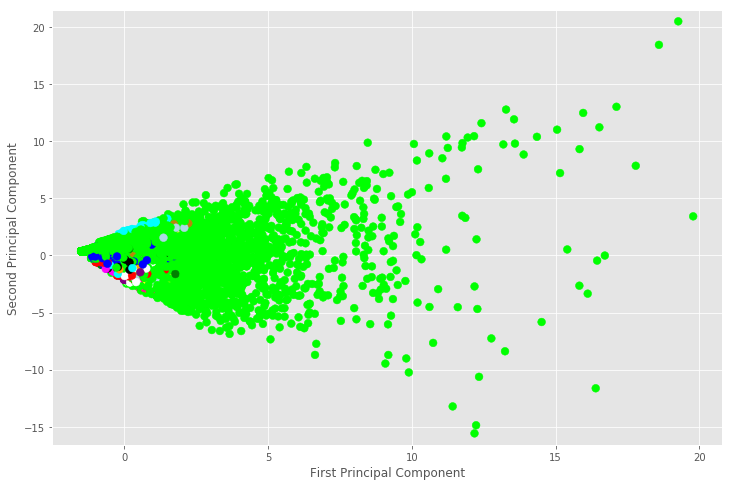

In [71]:
db_model = DBSCAN(eps=0.75, min_samples=4)
db_model.fit(ARPE_DBSCAN_input)
y_pred = db_model.fit_predict(ARPE_DBSCAN_input)



plt.rcParams['figure.figsize'] = (12, 8)
fig,ax1 = plt.subplots()

ax1.set_xlim(ARPE_PCA_dataframe["PC_1"].min()-1,ARPE_PCA_dataframe["PC_1"].max()+1)
ax1.set_ylim(ARPE_PCA_dataframe["PC_2"].min()-1,ARPE_PCA_dataframe["PC_2"].max()+1)

# Plot Principal Components 1 and 2
#for i,name in enumerate(violence_PCA_dataframe.index.values):
#    ax1.annotate(name, (violence_PCA_dataframe.iloc[i,0], violence_PCA_dataframe.iloc[i,1]), ha='center',fontsize=16)
plt.scatter(ARPE_PCA_dataframe["PC_1"], ARPE_PCA_dataframe["PC_2"],s=60, c=y_pred, cmap = cmap_bold)
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')



labels = db_model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(ARPE_DBSCAN_input.index, labels))
print("Completeness: %0.3f" % metrics.completeness_score(ARPE_DBSCAN_input.index, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(ARPE_DBSCAN_input.index, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(ARPE_DBSCAN_input.index, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(ARPE_DBSCAN_input, labels))

Estimated number of clusters: 60
Estimated number of noise points: 1325
Homogeneity: 0.190
Completeness: 1.000
V-measure: 0.320
Adjusted Rand Index: 0.000
Silhouette Coefficient: 0.265


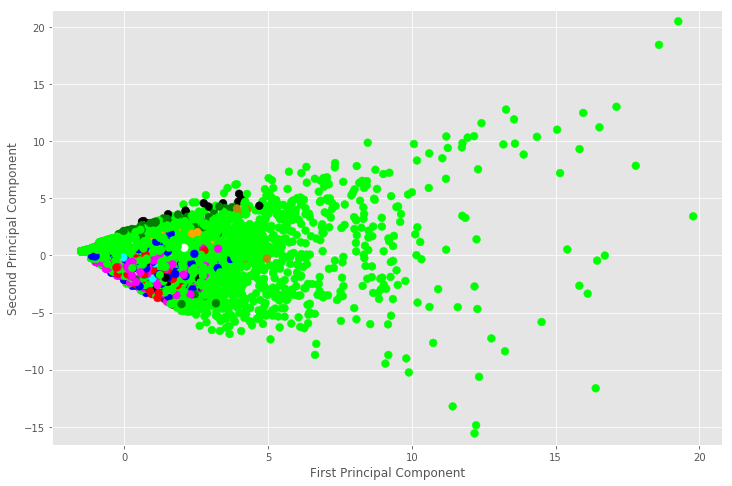

In [72]:
db_model = DBSCAN(eps=1.75, min_samples=4)
db_model.fit(ARPE_DBSCAN_input)
y_pred = db_model.fit_predict(ARPE_DBSCAN_input)



plt.rcParams['figure.figsize'] = (12, 8)
fig,ax1 = plt.subplots()

ax1.set_xlim(ARPE_PCA_dataframe["PC_1"].min()-1,ARPE_PCA_dataframe["PC_1"].max()+1)
ax1.set_ylim(ARPE_PCA_dataframe["PC_2"].min()-1,ARPE_PCA_dataframe["PC_2"].max()+1)

# Plot Principal Components 1 and 2
#for i,name in enumerate(violence_PCA_dataframe.index.values):
#    ax1.annotate(name, (violence_PCA_dataframe.iloc[i,0], violence_PCA_dataframe.iloc[i,1]), ha='center',fontsize=16)
plt.scatter(ARPE_PCA_dataframe["PC_1"], ARPE_PCA_dataframe["PC_2"],s=60, c=y_pred, cmap = cmap_bold)
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')



labels = db_model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(ARPE_DBSCAN_input.index, labels))
print("Completeness: %0.3f" % metrics.completeness_score(ARPE_DBSCAN_input.index, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(ARPE_DBSCAN_input.index, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(ARPE_DBSCAN_input.index, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(ARPE_DBSCAN_input, labels))

In [73]:
# Clusters = [] 
# Noise_points = [] 
# Homogenity = []
# V_Measure = []
# Silhouette = []


# eps_values = np.arange(0.5,10,0.1)
# for i in eps_values:
#     db_model = DBSCAN(eps=i, min_samples=2)
#     db_model.fit(ARPE_DBSCAN_input)
#     labels = db_model.labels_
#     n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#     n_noise_ = list(labels).count(-1)
#     Clusters.append(n_clusters_)
#     Noise_points.append(n_noise_)
#     Homogenity.append(metrics.homogeneity_score(ARPE_DBSCAN_input.index, labels))
#     V_Measure.append(metrics.v_measure_score(ARPE_DBSCAN_input.index, labels))
#     Silhouette.append(metrics.silhouette_score(ARPE_DBSCAN_input, labels))



In [76]:
#eps_values = np.arange(0.5,10,0.1)
# ARPE_DBSCAN_measures = pd.DataFrame({"eps_values": eps_values, "Clusters": Clusters, "Noise_points": Noise_points, "Homogenity": Homogenity,
#               "V_Measure":V_Measure, "Silhouette": Silhouette}) 
# ARPE_DBSCAN_measures.to_csv(output_path+"ARPE_DBSCAN_quality_measure_values.csv")

In [77]:
ARPE_DBSCAN_measures = pd.read_csv(output_path+"ARPE_DBSCAN_quality_measure_values.csv")
eps_values = ARPE_DBSCAN_measures[["eps_values"]].values
Silhouette = ARPE_DBSCAN_measures[["Silhouette"]].values
V_Measure = ARPE_DBSCAN_measures[["V_Measure"]].values
Homogenity = ARPE_DBSCAN_measures[["Homogenity"]].values
Noise_points = ARPE_DBSCAN_measures[["Noise_points"]].values
Clusters = ARPE_DBSCAN_measures[["Clusters"]].values


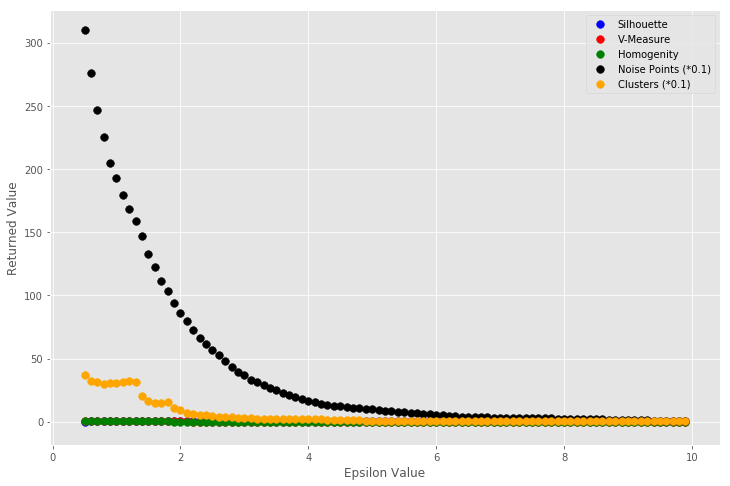

In [78]:
map_noise = [i*0.10 for i in Noise_points]
map_clusters = [i*0.10 for i in Clusters]

plt.scatter(eps_values, Silhouette,s=60, c = 'blue', label = "Silhouette")
plt.scatter(eps_values, V_Measure,s=60, c = 'red', label = "V-Measure")
plt.scatter(eps_values, Homogenity,s=60, c = 'green', label = "Homogenity")
plt.scatter(eps_values, map_noise,s=60, c = 'black', label = "Noise Points (*0.1)")
plt.scatter(eps_values, map_clusters,s=60, c = 'orange', label = "Clusters (*0.1)")

plt.xlabel('Epsilon Value')
plt.ylabel('Returned Value')
plt.legend()


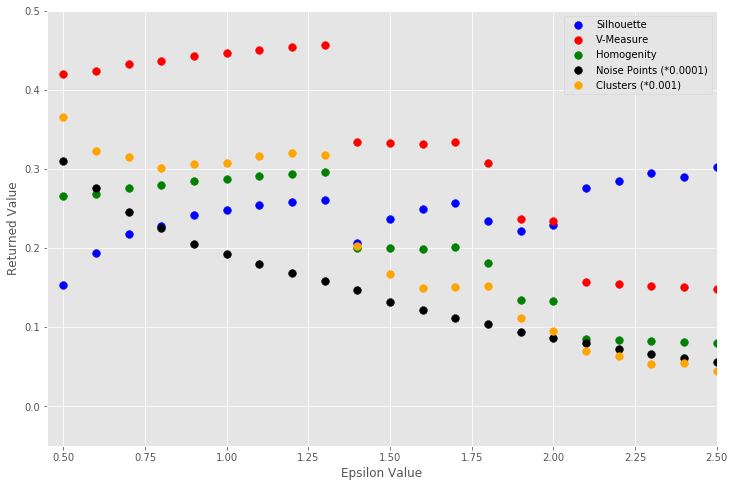

In [79]:
map_noise = [i*0.0001 for i in Noise_points]
map_clusters = [i*0.001 for i in Clusters]

plt.scatter(eps_values, Silhouette,s=60, c = 'blue', label = "Silhouette")
plt.scatter(eps_values, V_Measure,s=60, c = 'red', label = "V-Measure")
plt.scatter(eps_values, Homogenity,s=60, c = 'green', label = "Homogenity")
plt.scatter(eps_values, map_noise,s=60, c = 'black', label = "Noise Points (*0.0001)")
plt.scatter(eps_values, map_clusters,s=60, c = 'orange', label = "Clusters (*0.001)")

plt.xlabel('Epsilon Value')
plt.ylabel('Returned Value')
plt.ylim(-0.05, 0.5)
plt.xlim(0.45, 2.5)
plt.legend()

In [81]:
# Clusters = [] 
# Noise_points = [] 
# Homogenity = []
# V_Measure = []
# Silhouette = []


# eps_values = np.arange(1.0,1.5,0.01)
# for i in eps_values:
#     db_model = DBSCAN(eps=i, min_samples=2)
#     db_model.fit(ARPE_DBSCAN_input)
#     labels = db_model.labels_
#     n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#     n_noise_ = list(labels).count(-1)
#     Clusters.append(n_clusters_)
#     Noise_points.append(n_noise_)
#     Homogenity.append(metrics.homogeneity_score(ARPE_DBSCAN_input.index, labels))
#     V_Measure.append(metrics.v_measure_score(ARPE_DBSCAN_input.index, labels))
#     Silhouette.append(metrics.silhouette_score(ARPE_DBSCAN_input, labels))


In [80]:
#ARPE_DBSCAN_measures_concentrated = pd.DataFrame({"eps_values": eps_values, "Clusters": Clusters, "Noise_points": Noise_points, "Homogenity": Homogenity,
#              "V_Measure":V_Measure, "Silhouette": Silhouette}) 
#ARPE_DBSCAN_measures_concentrated.to_csv(output_path+"ARPE_DBSCAN_quality_measure_values_concentrated.csv")

In [82]:
ARPE_DBSCAN_measures_concentrated = pd.read_csv(output_path+"ARPE_DBSCAN_quality_measure_values_concentrated.csv")
eps_values = ARPE_DBSCAN_measures_concentrated[["eps_values"]].values
Silhouette = ARPE_DBSCAN_measures_concentrated[["Silhouette"]].values
V_Measure = ARPE_DBSCAN_measures_concentrated[["V_Measure"]].values
Homogenity = ARPE_DBSCAN_measures_concentrated[["Homogenity"]].values
Noise_points = ARPE_DBSCAN_measures_concentrated[["Noise_points"]].values
Clusters = ARPE_DBSCAN_measures_concentrated[["Clusters"]].values


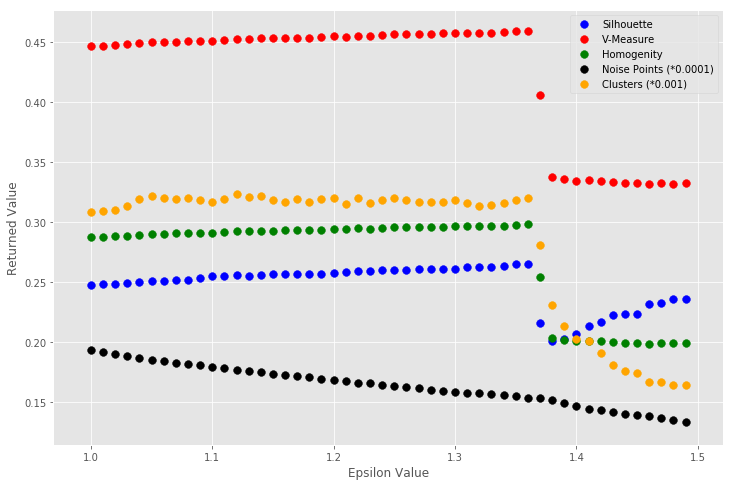

In [83]:
map_noise = [i*0.0001 for i in Noise_points]
map_clusters = [i*0.001 for i in Clusters]

plt.scatter(eps_values, Silhouette,s=60, c = 'blue', label = "Silhouette")
plt.scatter(eps_values, V_Measure,s=60, c = 'red', label = "V-Measure")
plt.scatter(eps_values, Homogenity,s=60, c = 'green', label = "Homogenity")
plt.scatter(eps_values, map_noise,s=60, c = 'black', label = "Noise Points (*0.0001)")
plt.scatter(eps_values, map_clusters,s=60, c = 'orange', label = "Clusters (*0.001)")

plt.xlabel('Epsilon Value')
plt.ylabel('Returned Value')
#plt.ylim(-0.05, 0.5)
#plt.xlim(0.45, 2.5)
plt.savefig(output_path+"ARPE_DBSCAN_finding_epsilon.png", dpi=300) # size above specified at 10x6
plt.legend()

Estimated number of clusters: 320
Estimated number of noise points: 1537
Homogeneity: 0.298
Completeness: 1.000
V-measure: 0.459
Adjusted Rand Index: 0.000
Silhouette Coefficient: 0.265


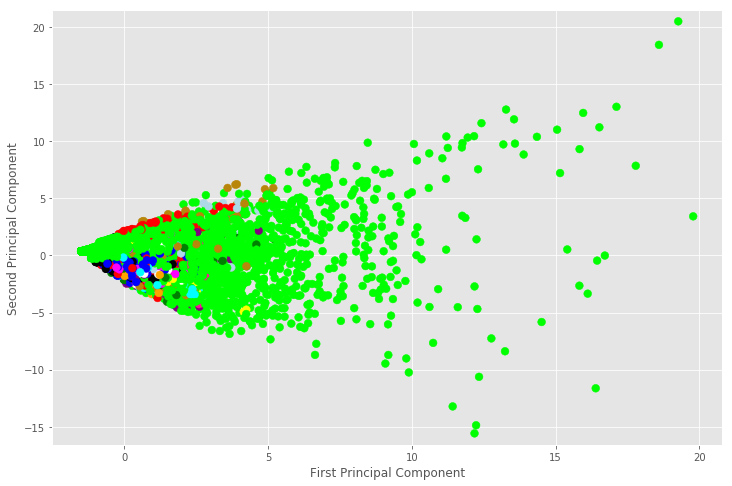

In [84]:
db_model = DBSCAN(eps=1.36, min_samples=2)
db_model.fit(ARPE_DBSCAN_input)
y_pred = db_model.fit_predict(ARPE_DBSCAN_input)



plt.rcParams['figure.figsize'] = (12, 8)
fig,ax1 = plt.subplots()

ax1.set_xlim(ARPE_PCA_dataframe["PC_1"].min()-1,ARPE_PCA_dataframe["PC_1"].max()+1)
ax1.set_ylim(ARPE_PCA_dataframe["PC_2"].min()-1,ARPE_PCA_dataframe["PC_2"].max()+1)

# Plot Principal Components 1 and 2
#for i,name in enumerate(violence_PCA_dataframe.index.values):
#    ax1.annotate(name, (violence_PCA_dataframe.iloc[i,0], violence_PCA_dataframe.iloc[i,1]), ha='center',fontsize=16)
plt.scatter(ARPE_PCA_dataframe["PC_1"], ARPE_PCA_dataframe["PC_2"],s=60, c=y_pred, cmap = cmap_bold)
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.savefig(output_path+"ARPE_DBSCAN_PCA_plot.png", dpi=300) 


labels = db_model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(ARPE_DBSCAN_input.index, labels))
print("Completeness: %0.3f" % metrics.completeness_score(ARPE_DBSCAN_input.index, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(ARPE_DBSCAN_input.index, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(ARPE_DBSCAN_input.index, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(ARPE_DBSCAN_input, labels))

In [85]:

ARPE_Normalized["DBSCAN_Cluster"] = y_pred
ARPE_Normalized.to_csv(output_path+"ARPE_Cluster_Info_Kmeans_DBSCAN.csv")
ARPE_Normalized.head()

,Length,Exon_Length,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,Downstream_Promoter_Downregulated,TSS_Downregulated,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,Downstream_Promoter_Nondifferential,TSS_Nondifferential,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Downstream_Promoter_Upregulated,TSS_Upregulated,Change,Group_K_Means,DBSCAN_Cluster
Ensembl_ID,,,,,,,,,,,,,,,,,
ENSG00000000003,-0.459008,0.111174,-0.243516,-0.11298,-0.103286,-0.051755,-0.434994,-0.423382,-0.414895,4.062426,-0.392168,-0.452456,-0.469535,-0.29699,Downregulated,10,0
ENSG00000000419,-0.339981,-0.807101,-0.243516,-0.11298,-0.103286,-0.051755,-0.434994,-0.423382,-0.414895,-0.211054,-0.185793,-0.452456,-0.469535,-0.29699,Nondifferential,2,1
ENSG00000000457,-0.160628,1.006100,-0.243516,-0.11298,-0.103286,-0.051755,-0.170512,-0.423382,-0.414895,-0.211054,-0.185793,-0.452456,-0.469535,-0.29699,Nondifferential,12,1
ENSG00000000460,-0.035890,0.305980,-0.243516,-0.11298,-0.103286,-0.051755,0.622934,-0.423382,-0.414895,-0.211054,0.020582,-0.452456,-0.469535,-0.29699,Nondifferential,2,1
ENSG00000000971,0.285342,0.226524,-0.243516,-0.11298,-0.103286,-0.051755,-0.170512,-0.423382,1.604796,-0.211054,-0.392168,-0.452456,-0.469535,-0.29699,Upregulated,5,2


In [86]:
DBSCAN_outliers = ARPE_Normalized[ARPE_Normalized["DBSCAN_Cluster"] ==-1]

In [87]:
len(DBSCAN_outliers)

1537

In [88]:
DBSCAN_PCA = ARPE_PCA_dataframe.drop(DBSCAN_outliers.index, axis = 0)
DBSCAN_PCA = DBSCAN_PCA.join(ARPE_Normalized)
DBSCAN_PCA.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,Upstream_Promoter_Nondifferential,Downstream_Promoter_Nondifferential,TSS_Nondifferential,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Downstream_Promoter_Upregulated,TSS_Upregulated,Change,Group_K_Means,DBSCAN_Cluster
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,-0.640045,-0.188427,1.841298,0.937859,-1.991830,-1.449293,2.178476,-1.399587,0.249624,0.664050,...,-0.423382,-0.414895,4.062426,-0.392168,-0.452456,-0.469535,-0.29699,Downregulated,10,0
ENSG00000000419,-1.216522,0.405485,-0.292359,-0.034832,-0.047796,0.003209,0.234372,0.149249,-0.001175,-0.210136,...,-0.423382,-0.414895,-0.211054,-0.185793,-0.452456,-0.469535,-0.29699,Nondifferential,2,1
ENSG00000000457,-0.498389,0.428928,-0.093635,-0.019118,0.010013,0.036167,-0.543828,-0.761906,-0.005122,0.856184,...,-0.423382,-0.414895,-0.211054,-0.185793,-0.452456,-0.469535,-0.29699,Nondifferential,12,1
ENSG00000000460,-0.197492,0.752827,-0.276014,-0.050884,-0.025533,-0.001420,-0.204509,-0.388151,-0.006659,0.397217,...,-0.423382,-0.414895,-0.211054,0.020582,-0.452456,-0.469535,-0.29699,Nondifferential,2,1
ENSG00000000971,-0.243824,0.222818,0.736689,0.071910,-0.185251,-0.181850,-0.998903,0.188153,-1.340648,-0.032990,...,-0.423382,1.604796,-0.211054,-0.392168,-0.452456,-0.469535,-0.29699,Upregulated,5,2


In [89]:
print(len(ARPE_PCA_dataframe))
print(len(DBSCAN_PCA))


14599
13062


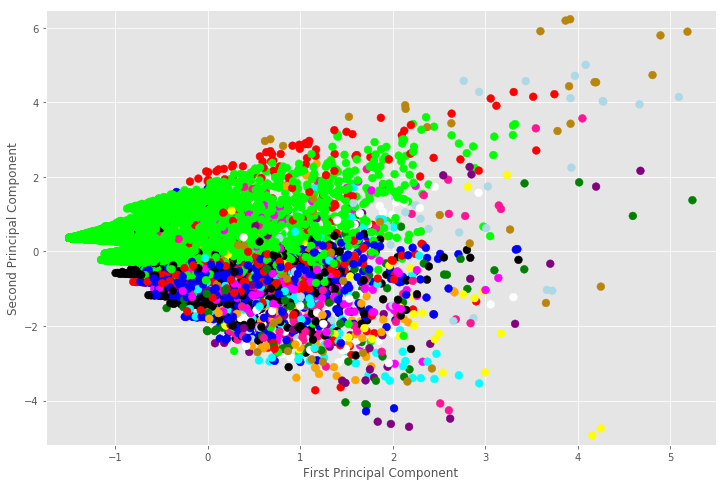

In [90]:
plt.rcParams['figure.figsize'] = (12, 8)
fig,ax1 = plt.subplots()

ax1.set_xlim(DBSCAN_PCA["PC_1"].min()-0.25,DBSCAN_PCA["PC_1"].max()+0.25)
ax1.set_ylim(DBSCAN_PCA["PC_2"].min()-0.25,DBSCAN_PCA["PC_2"].max()+0.25)

# Plot Principal Components 1 and 2
#for i,name in enumerate(violence_PCA_dataframe.index.values):
#    ax1.annotate(name, (violence_PCA_dataframe.iloc[i,0], violence_PCA_dataframe.iloc[i,1]), ha='center',fontsize=16)
plt.scatter(DBSCAN_PCA["PC_1"], DBSCAN_PCA["PC_2"],s=60, c=DBSCAN_PCA["DBSCAN_Cluster"], cmap = cmap_bold)
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.savefig(output_path+"ARPE_DBSCAN_PCA_without_outliers_plot.png", dpi=300) 


Well, DBSCAN gave me 320 clusters with 1,537 noise points (about 10% of the data). Homogeneity was 29.8% and the silhouette coefficient was 26.5% while the V-measure was 45.9%. Although these numbers aren't great, it does look like things cluster rather well on the PCA plot. It looks like a third dimension would benefit the graph. The largest cluster is cluster 1 (the green one) with 6,032 genes. The next largest cluster only has 782 genes. I am interested to see if these genes cluster in a given pathway or something like that. I will have to look into that next.  
